In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from datetime import datetime
import warnings
import sys
import os

In [2]:
from google.colab import files
uploaded= files.upload()

Saving marketing_campaign.xlsx to marketing_campaign.xlsx


In [3]:
df= pd.read_excel("marketing_campaign.xlsx")
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0   0        1985  Graduation        Married  70951.0        0         0   
1   1        1961  Graduation         Single  57091.0        0         0   
2   9        1975      Master         Single  46098.0        1         1   
3  13        1947         PhD          Widow  25358.0        0         1   
4  17        1971         PhD        Married  60491.0        0         1   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2013-05-04       66       239  ...                  1             0   
1  2014-06-15        0       464  ...                  5             0   
2  2012-08-18       86        57  ...                  8             0   
3  2013-07-22       57        19  ...                  6             0   
4  2013-09-06       81       637  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             1         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         0  
1              3         11         1  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

In [5]:
df.shape

(2240, 29)

In [6]:
warnings.filterwarnings('ignore')  # ignore notifications

In [7]:
df.duplicated().sum()

0

In [8]:
df['Age'] = datetime.now().year - df['Year_Birth'] # Client Age

The code calculates the age of the clients by subtracting their birth year from the current year, and assigns the calculated values to a new column named 'Age' in the DataFrame 'df'.

In [9]:
def get_different_year():
    registration_year = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d').apply(lambda x: x.year)
    current_year = datetime.now().year
    return current_year - registration_year

df['Years_Since_Registration'] = get_different_year()  # Number of years since customer registration

The code defines a function get_different_year() that calculates the number of years since customer registration based on the 'Dt_Customer' column in the DataFrame. It then assigns the calculated values to a new column named 'Years_Since_Registration' in the DataFrame 'df'.

In [10]:
df["Education"] = df["Education"].replace({"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3})
# Encoded in numbers in order

The code replaces the categorical values in the 'Education' column with corresponding numerical values, where "Basic" is replaced with 0, "Graduation" with 1, "2n Cycle" and "Master" with 2, and "PhD" with 3. This encoding represents the education levels in ascending order.

In [11]:
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

step_2 = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})

df["Family_Size"] = step_2 + df['Kidhome'] + df['Teenhome']  # Total number of people in the family

df = pd.concat([df, pd.get_dummies(df['Marital_Status'])], axis=1)  # Separate features for Alone and Partner

The code replaces certain values in the "Marital_Status" column and assigns numerical values to the modified values. It then calculates the total number of people in the family based on the modified values and other columns. Finally, it creates separate features for "Alone" and "Partner" using one-hot encoding.

In [12]:
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)  # Total amount spent on products

The code calculates the total amount spent on different products by summing the values in the specified columns ('MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'), and assigns the result to a new column named 'Sum_Mnt' in the DataFrame 'df'.

In [13]:
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                     'Response']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].sum(axis=1)
# Number of companies in which the client accepted the offer

The code calculates the number of companies in which the client accepted the offer by summing the values in the specified columns ('AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'), and assigns the result to a new column named 'Num_Accepted_Cmp' in the DataFrame 'df'.

In [14]:
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)  # Total number of purchases

The code calculates the total number of purchases made by summing the values in the specified columns ('NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'), and assigns the result to a new column named 'Num_Total_Purchases' in the DataFrame 'df'.

## Plotting the data

## Histogram of Products

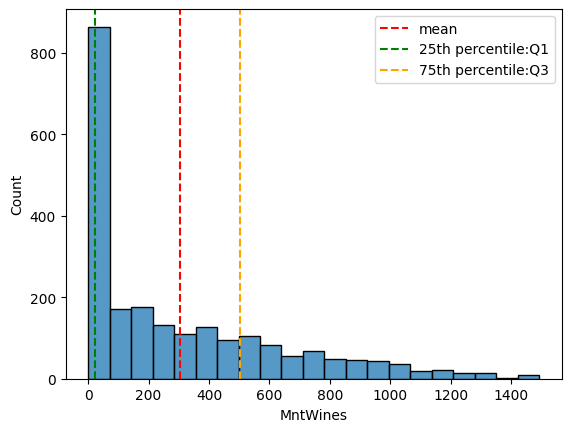

In [15]:
sns.histplot(df['MntWines'])
plt.axvline(x=np.mean(df['MntWines']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntWines'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntWines'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

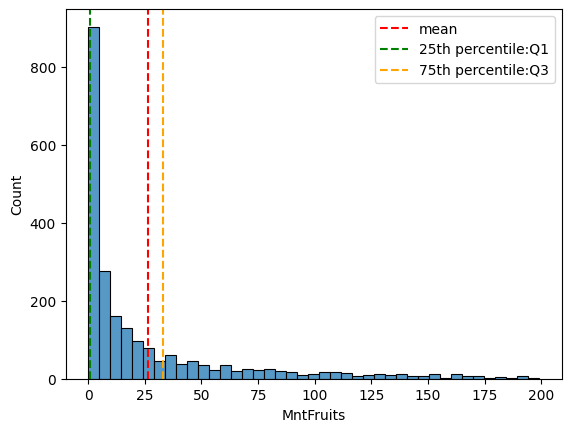

In [16]:
sns.histplot(df['MntFruits'])
plt.axvline(x=np.mean(df['MntFruits']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntFruits'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntFruits'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

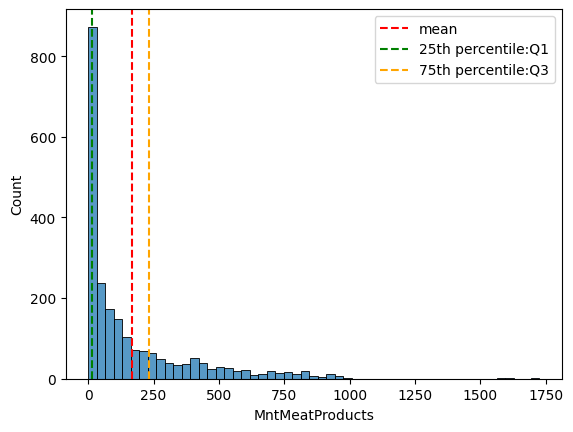

In [17]:
sns.histplot(df['MntMeatProducts'])
plt.axvline(x=np.mean(df['MntMeatProducts']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntMeatProducts'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntMeatProducts'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

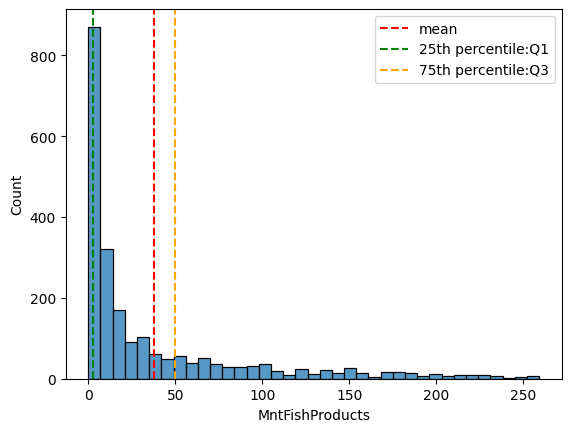

In [18]:
sns.histplot(df['MntFishProducts'])
plt.axvline(x=np.mean(df['MntFishProducts']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntFishProducts'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntFishProducts'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

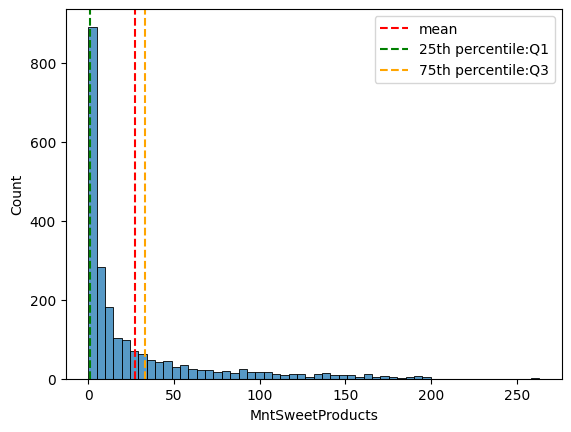

In [19]:
sns.histplot(df['MntSweetProducts'])
plt.axvline(x=np.mean(df['MntSweetProducts']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntSweetProducts'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntSweetProducts'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

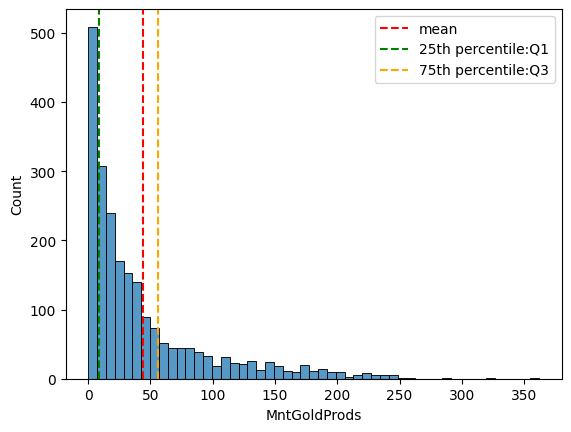

In [20]:
sns.histplot(df['MntGoldProds'])
plt.axvline(x=np.mean(df['MntGoldProds']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['MntGoldProds'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['MntGoldProds'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

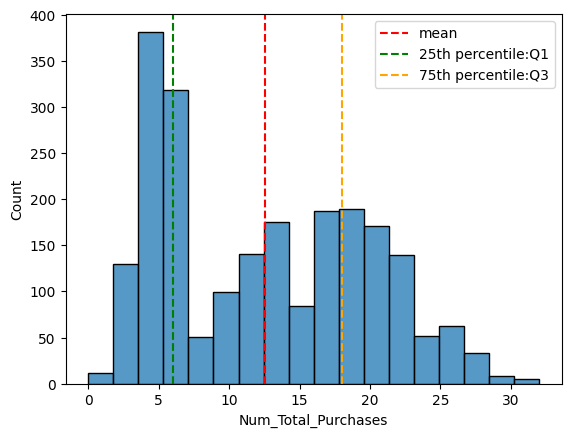

In [21]:
sns.histplot(df['Num_Total_Purchases'])
plt.axvline(x=np.mean(df['Num_Total_Purchases']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['Num_Total_Purchases'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['Num_Total_Purchases'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

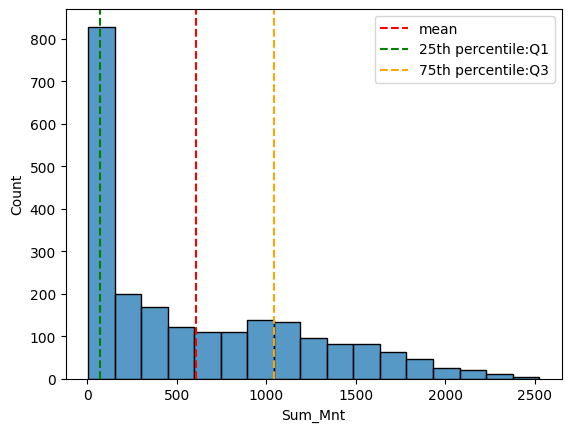

In [22]:
sns.histplot(df['Sum_Mnt'])
plt.axvline(x=np.mean(df['Sum_Mnt']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['Sum_Mnt'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['Sum_Mnt'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

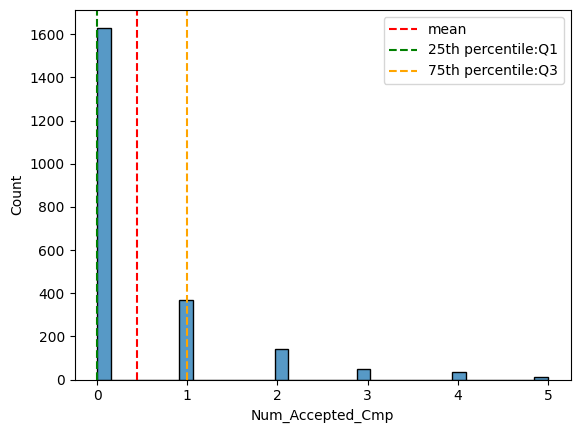

In [23]:
sns.histplot(df['Num_Accepted_Cmp'])
plt.axvline(x=np.mean(df['Num_Accepted_Cmp']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(df['Num_Accepted_Cmp'],25),c='green', ls='--', label = '25th percentile:Q1')
plt.axvline(x=np.percentile(df['Num_Accepted_Cmp'],75),c='orange', ls='--',label = '75th percentile:Q3' )
plt.legend()

In [24]:
# Create a kernel density plot
# df.Recency.plot(kind='kde')

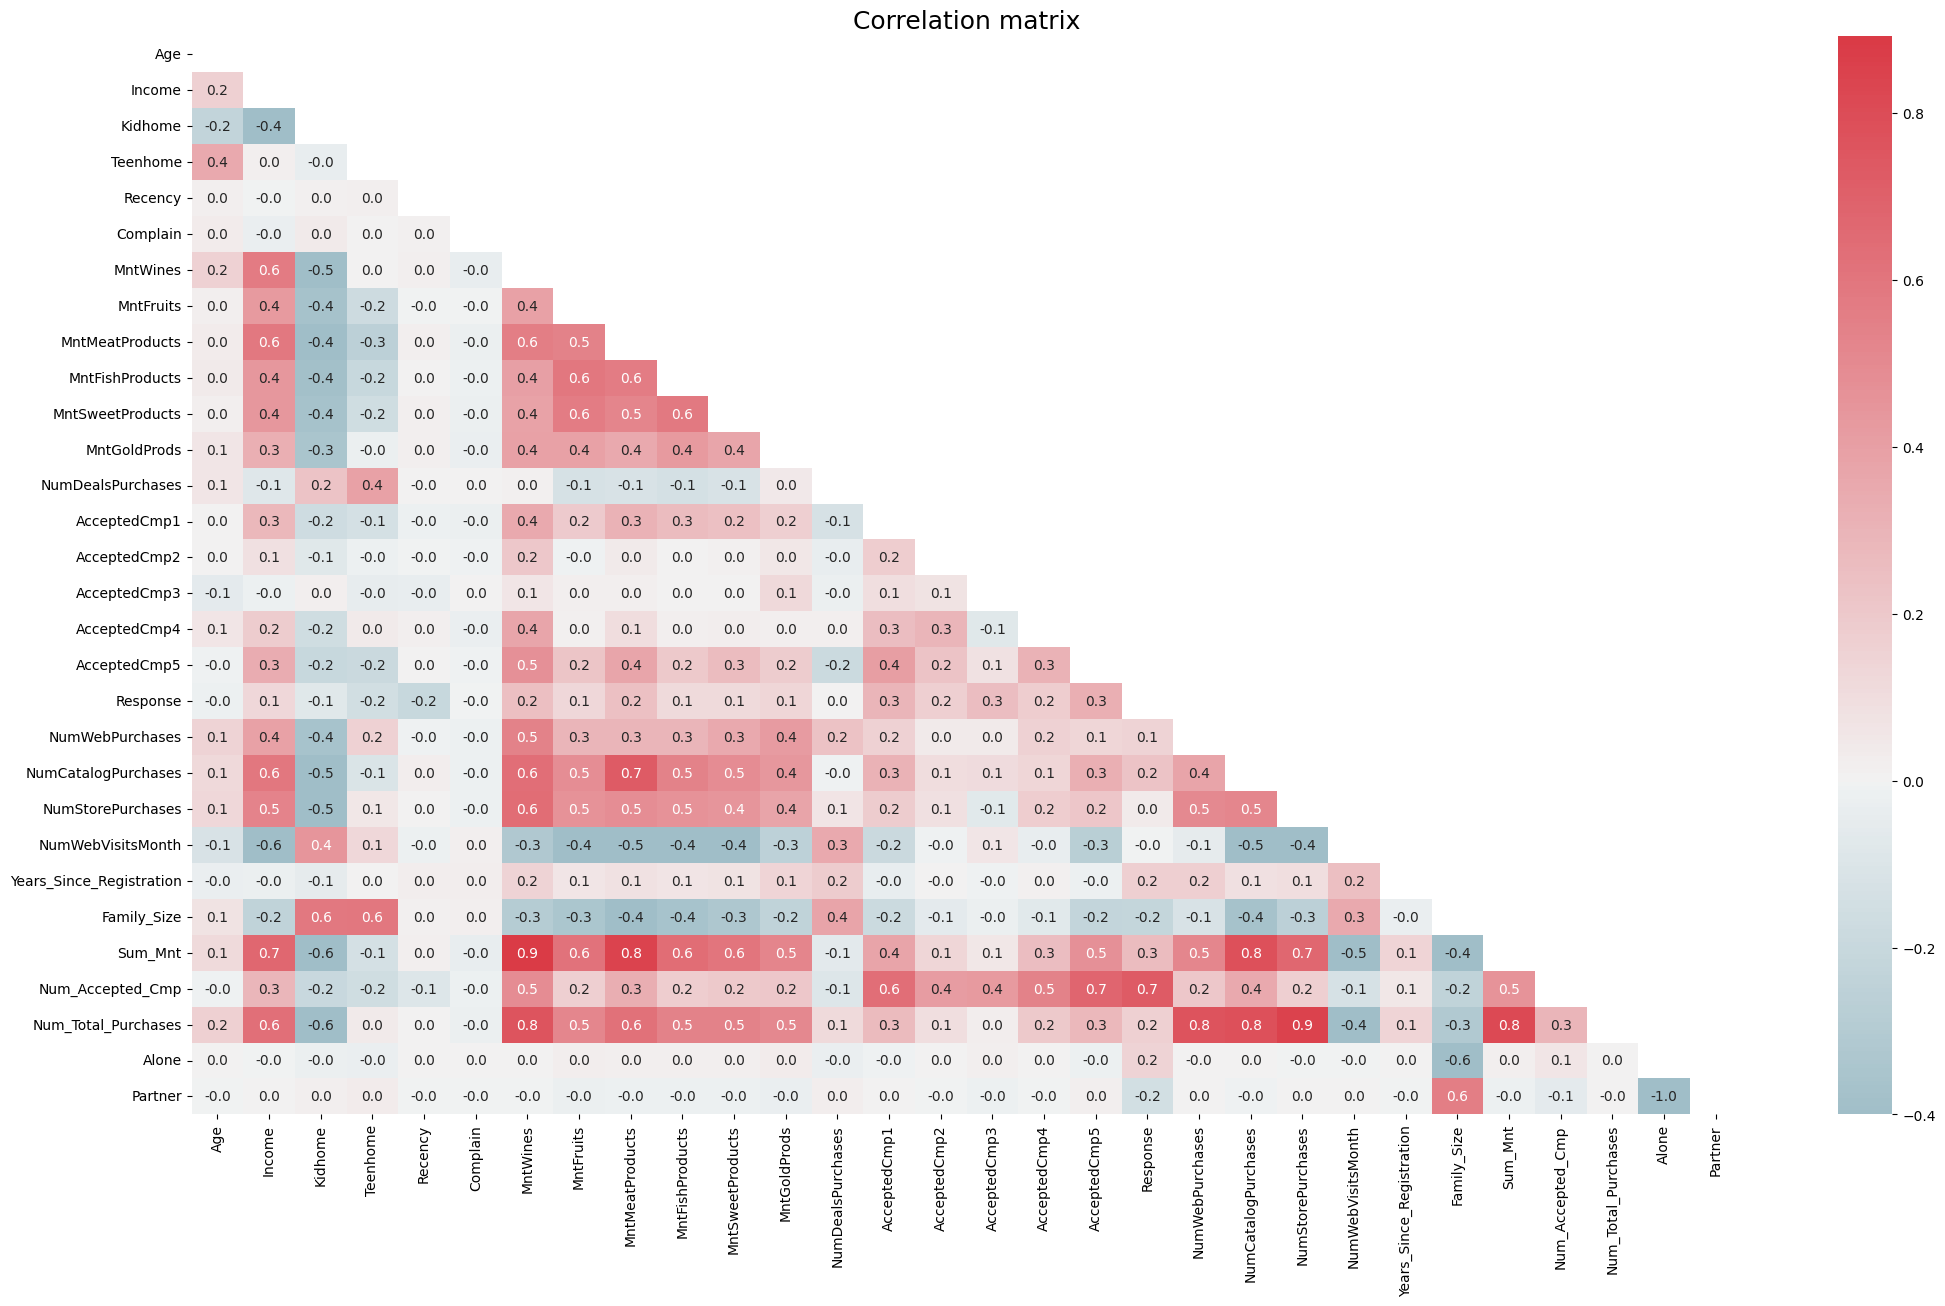

In [25]:
to_corr = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain',
          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
          'MntGoldProds', 'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
          'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebPurchases', 'NumCatalogPurchases',
          'NumStorePurchases', 'NumWebVisitsMonth', 'Years_Since_Registration', 'Family_Size',
           'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases', 'Alone', 'Partner']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()

In the product section we can see Meat & Wine are most prominent purchases, contributing max in sum_amt. Then from Store it is giving the maximum sales then web and catalog, whereas Website visit sale is the least.

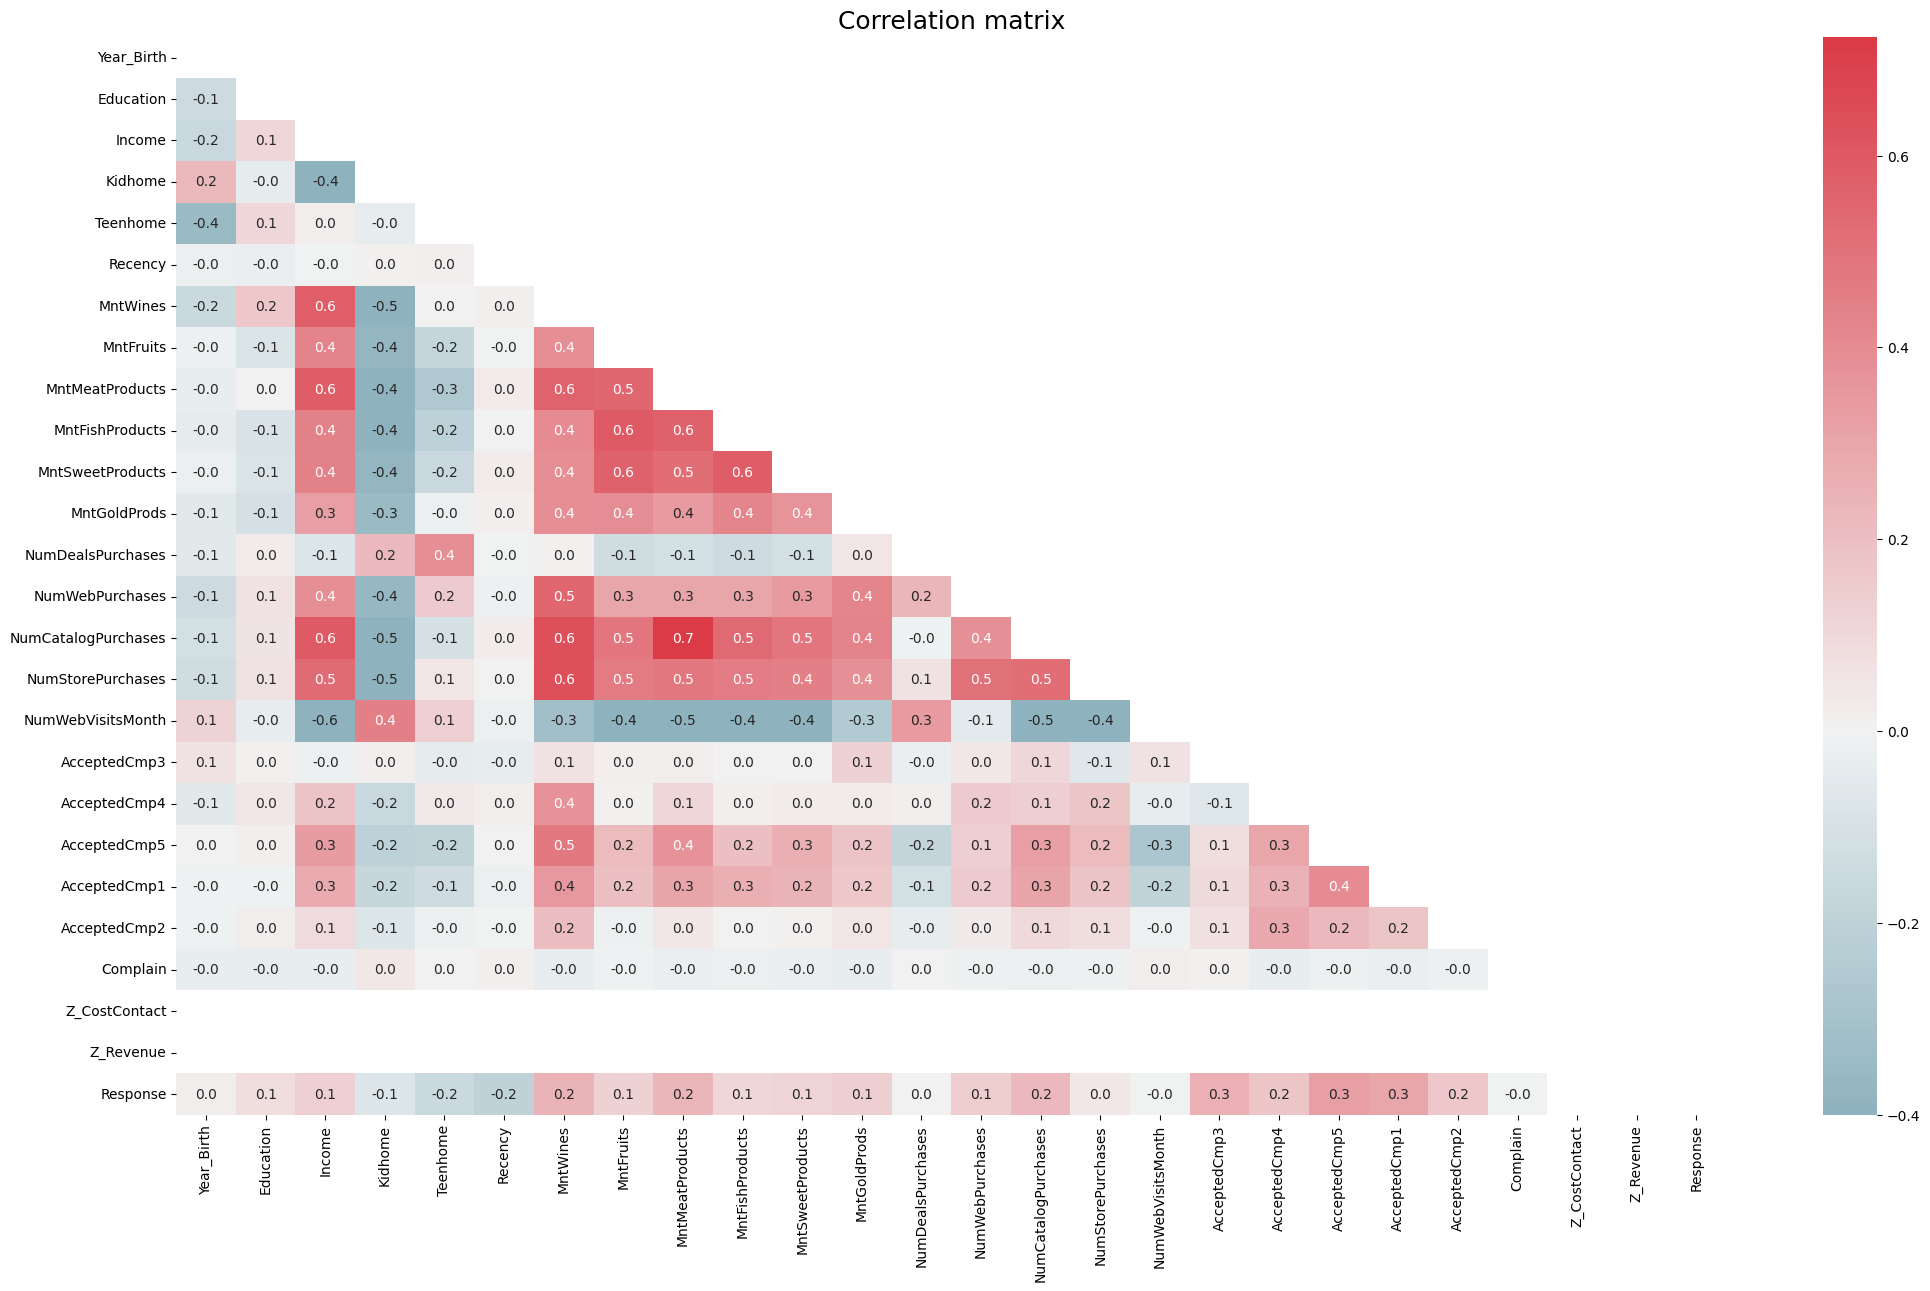

In [26]:
to_corr = ['Year_Birth','Education','Marital_Status','Income','Kidhome','Teenhome','Dt_Customer','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Complain','Z_CostContact','Z_Revenue','Response']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()

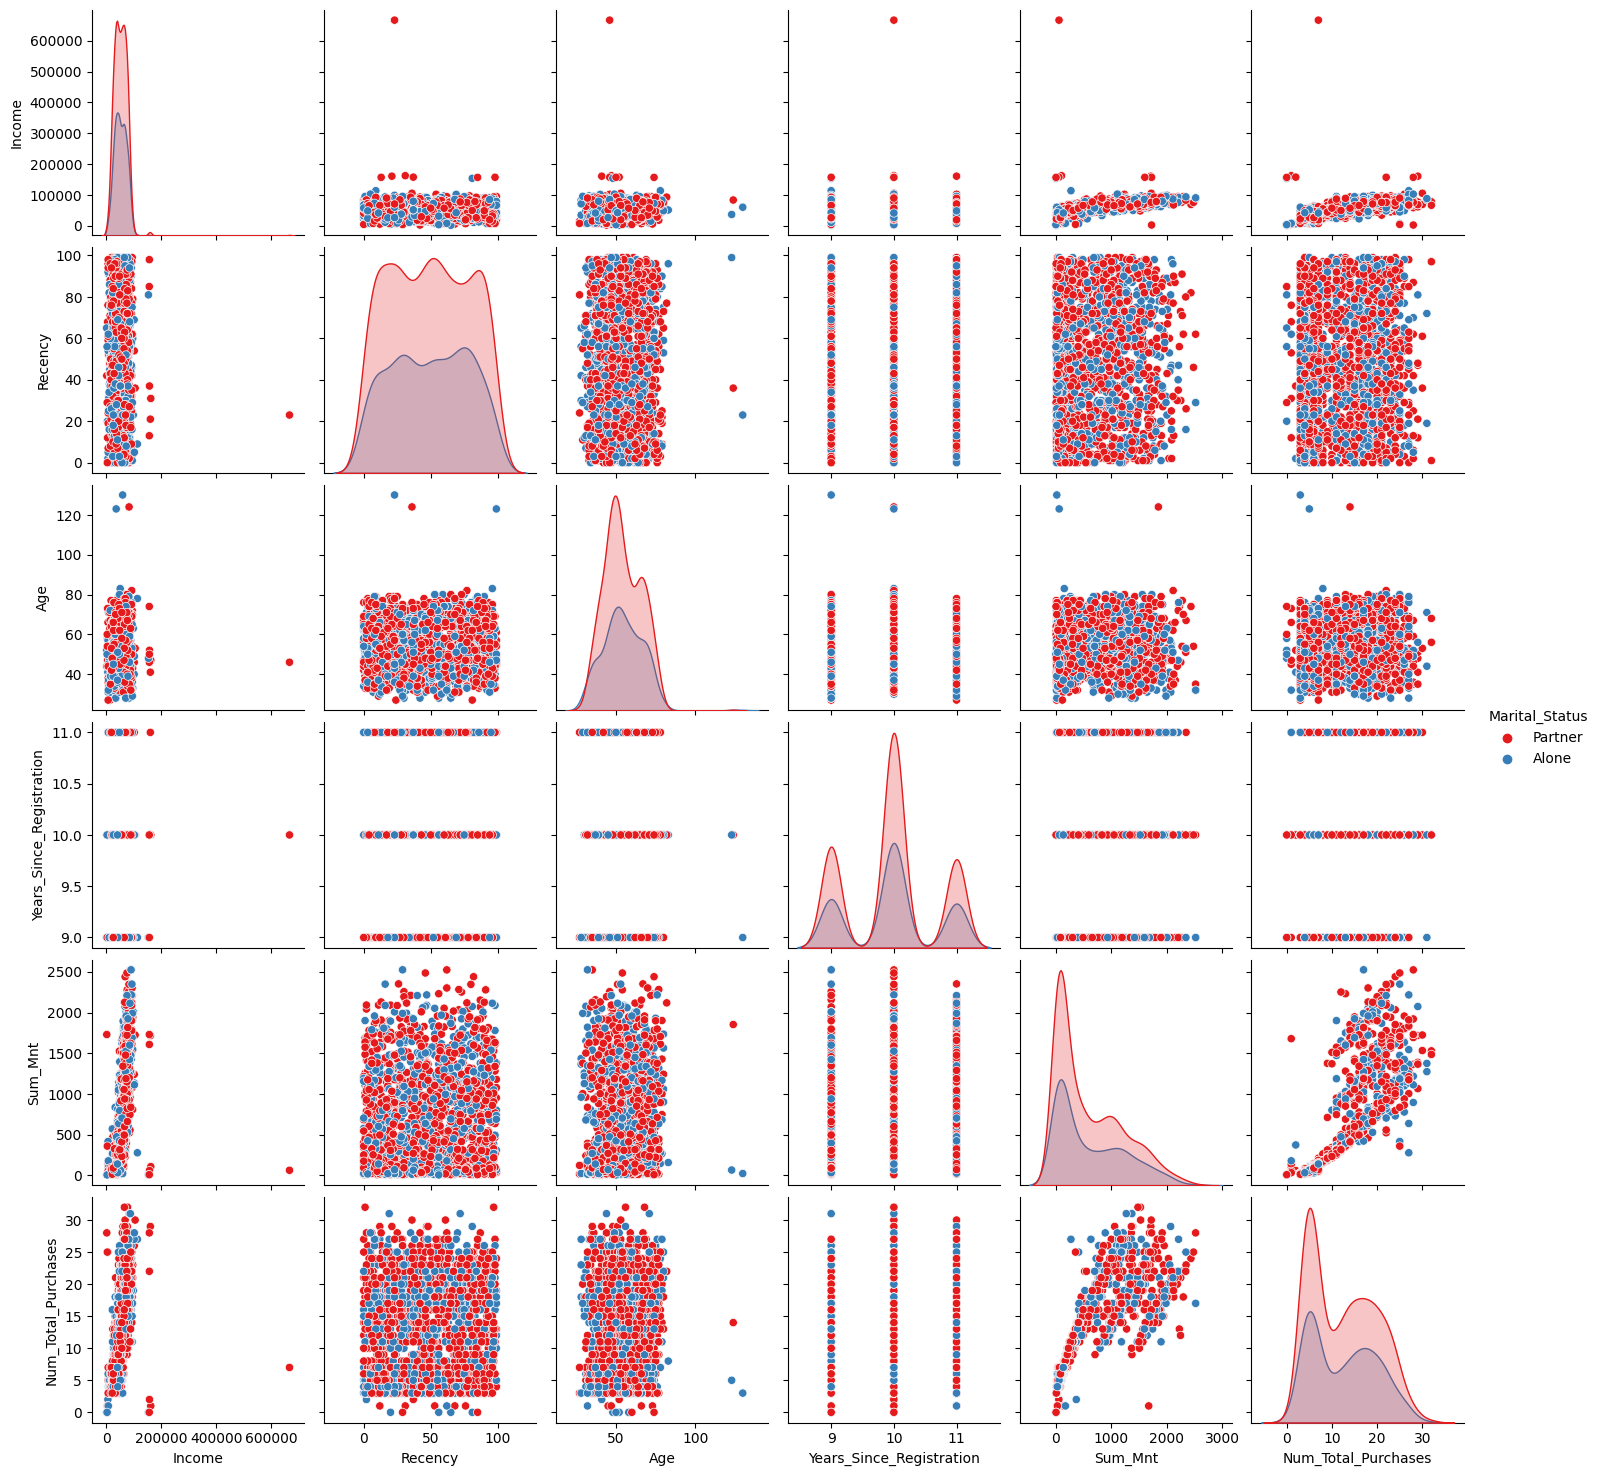

"\nThis code generates a pair plot using seaborn to visualize the relationships between multiple variables in the DataFrame df,\nwith the data points colored based on the 'Marital_Status' column. The resulting plot is then displayed using plt.show()."

In [27]:
to_plot = ['Income', 'Recency', 'Age', 'Years_Since_Registration', 'Sum_Mnt',
           'Num_Total_Purchases', 'Marital_Status']
sns.pairplot(df[to_plot], hue='Marital_Status', palette='Set1')
plt.show()
'''
This code generates a pair plot using seaborn to visualize the relationships between multiple variables in the DataFrame df,
with the data points colored based on the 'Marital_Status' column. The resulting plot is then displayed using plt.show().'''

Partners are contributing more compared to alone in all columns like Income, Age, Recency, Years_since_registration, Sum_Mnt, Num_Total_Purchases.


## Remove Null values in the data:

In [28]:
df.isna().sum()

ID                           0
Year_Birth                   0
Education                    0
Marital_Status               0
Income                      24
Kidhome                      0
Teenhome                     0
Dt_Customer                  0
Recency                      0
MntWines                     0
MntFruits                    0
MntMeatProducts              0
MntFishProducts              0
MntSweetProducts             0
MntGoldProds                 0
NumDealsPurchases            0
NumWebPurchases              0
NumCatalogPurchases          0
NumStorePurchases            0
NumWebVisitsMonth            0
AcceptedCmp3                 0
AcceptedCmp4                 0
AcceptedCmp5                 0
AcceptedCmp1                 0
AcceptedCmp2                 0
Complain                     0
Z_CostContact                0
Z_Revenue                    0
Response                     0
Age                          0
Years_Since_Registration     0
Family_Size                  0
Alone   

In [29]:
# df['Income'].fillna(df['Income'].median, inplace= True)
df.dropna(inplace= True) # Removed objects with gaps in income

In [30]:
df.isna().sum()

ID                          0
Year_Birth                  0
Education                   0
Marital_Status              0
Income                      0
Kidhome                     0
Teenhome                    0
Dt_Customer                 0
Recency                     0
MntWines                    0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Z_CostContact               0
Z_Revenue                   0
Response                    0
Age                         0
Years_Since_Registration    0
Family_Size                 0
Alone                       0
Partner   

## Remove unnecessary features:

In [31]:
df.drop(['Year_Birth', 'ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Marital_Status'], axis=1, inplace=True)

## Remove outliers in the data:

In [32]:
import seaborn as sns
color_pal = sns.color_palette("GnBu")

In [33]:
def remove_outliers(df, column):
    # Convert column to numeric values
    df[column] = pd.to_numeric(df[column], errors='coerce')

    # Calculate percentiles and bounds
    q3, q1 = np.nanpercentile(df[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    # Apply capping
    df[column] = np.clip(df[column], lower_bound, upper_bound)

    # Count outliers (optional, but we'll still return the count)
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    num_outliers = outliers.sum()

    # Remove outliers
    df = df[~outliers]

    return df, num_outliers

# Assuming df is your DataFrame containing the data

columns_to_remove_outliers = [
    'Age', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth', 'Years_Since_Registration', 'Sum_Mnt',
    'Num_Accepted_Cmp', 'Num_Total_Purchases'
]

#### Tukey's fences method for capping outliers.

Apply capping using np.clip(), which replaces any values below the lower bound with the lower bound value and any values above the upper bound with the upper bound value.

In [34]:
df.shape

(2216, 31)

In [35]:
df.tail(5)

Education    Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
2235          2   42394.0        1         0       69        15          2   
2236          3  156924.0        0         0       85         2          1   
2237          0   26487.0        1         0       23         2          8   
2238          1   26091.0        1         1       84        15         10   
2239          1   41411.0        0         0       11        37         32   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Complain  \
2235               10                0                 1  ...         0   
2236                2                1                 1  ...         0   
2237               10               12                14  ...         0   
2238               19                8                17  ...         0   
2239               38               11                 3  ...         0   

      Response  Age  Years_Since_Registration  Family_Size  Alone  Partner  \
2235         0   51                         9            2      1        0   
2236         0   74                        10            2      0        1   
2237         0   45                        10            2      1        0   
2238         0   66                         9            4      0        1   
2239         0   37                        10            1      1        0   

      Sum_Mnt  Num_Accepted_Cmp  Num_Total_Purchases  
2235       32                 0                    4  
2236        8                 0                    0  
2237       69                 0                    6  
2238       89                 0                    6  
2239      139                 0                    7  

[5 rows x 31 columns]

## Removing Duplicated values

In [36]:
df.duplicated().sum()

185

In [37]:
df.drop_duplicates(inplace=True)

In [38]:
df.duplicated().sum()

0

In [39]:
df.head()

Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0          1  70951.0        0         0       66       239         10   
1          1  57091.0        0         0        0       464          5   
2          2  46098.0        1         1       86        57          0   
3          3  25358.0        0         1       57        19          0   
4          3  60491.0        0         1       81       637         47   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Complain  \
0              554              254                87  ...         0   
1               64                7                 0  ...         0   
2               27                0                 0  ...         0   
3                5                0                 0  ...         0   
4              237               12                19  ...         0   

   Response  Age  Years_Since_Registration  Family_Size  Alone  Partner  \
0         0   38                        10            2      0        1   
1         1   62                         9            1      1        0   
2         0   48                        11            3      1        0   
3         0   76                        10            2      1        0   
4         0   52                        10            3      0        1   

   Sum_Mnt  Num_Accepted_Cmp  Num_Total_Purchases  
0     1198                 0                   16  
1      577                 2                   17  
2      120                 0                    7  
3       32                 0                    4  
4     1028                 0                   24  

[5 rows x 31 columns]

In [40]:
df.shape

(2031, 31)

## Data Scaling:
Data scaling is necessary to bring all features to the same scale. If this is not done, then the attention of the algorithm will be attracted to features that include large values (this is bad)  
In this work, normalization will be used as data scaling (as a result of normalization, all features are in the range from 0 to 1)

### Normalization
Reason for selecting Normalization, as it is performing better in the clustering.
(1. Normalization:
pca= 4
eps= 0.3, min_samples= 8,
DBSCAN,
Number of clusters formed: 7,
Silhouette score: 0.5170494949516974

2. Standardization:
pca= 4
eps= 0.3, min_samples= 8,
DBSCAN,
Number of clusters formed: 5,
Silhouette score: 0.10271717719684685)

In [41]:
def scaling_func(df:pd.DataFrame) -> None:
    mms = MinMaxScaler()
    return pd.DataFrame(data= mms.fit_transform(df), columns = df.columns)

df_scaled = scaling_func(df)
df_scaled.index = df.index # for convenient work with dataframes

In [42]:
df_scaled.head()

Education    Income  Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0   0.333333  0.104102      0.0       0.0  0.666667  0.160080   0.050251   
1   0.333333  0.083258      0.0       0.0  0.000000  0.310784   0.025126   
2   0.666667  0.066725      0.5       0.5  0.868687  0.038178   0.000000   
3   1.000000  0.035534      0.0       0.5  0.575758  0.012726   0.000000   
4   1.000000  0.088371      0.0       0.5  0.818182  0.426658   0.236181   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Complain  \
0         0.321159         0.980695          0.332061  ...       0.0   
1         0.037101         0.027027          0.000000  ...       0.0   
2         0.015652         0.000000          0.000000  ...       0.0   
3         0.002899         0.000000          0.000000  ...       0.0   
4         0.137391         0.046332          0.072519  ...       0.0   

   Response       Age  Years_Since_Registration  Family_Size  Alone  Partner  \
0       0.0  0.106796                       0.5         0.25    0.0      1.0   
1       1.0  0.339806                       0.0         0.00    1.0      0.0   
2       0.0  0.203883                       1.0         0.50    1.0      0.0   
3       0.0  0.475728                       0.5         0.25    1.0      0.0   
4       0.0  0.242718                       0.5         0.50    0.0      1.0   

    Sum_Mnt  Num_Accepted_Cmp  Num_Total_Purchases  
0  0.473413               0.0              0.50000  
1  0.226984               0.4              0.53125  
2  0.045635               0.0              0.21875  
3  0.010714               0.0              0.12500  
4  0.405952               0.0              0.75000  

[5 rows x 31 columns]

In [43]:
print(df_scaled.isnull().sum())

Education                   0
Income                      0
Kidhome                     0
Teenhome                    0
Recency                     0
MntWines                    0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Response                    0
Age                         0
Years_Since_Registration    0
Family_Size                 0
Alone                       0
Partner                     0
Sum_Mnt                     0
Num_Accepted_Cmp            0
Num_Total_Purchases         0
dtype: int64


## & Dimensionality Reduction

In [44]:
from sklearn.decomposition import PCA

def dim_reduction(data: pd.DataFrame) -> pd.DataFrame:
    n_components = 4
    pca = PCA(n_components, random_state=42)
    pca_result = pca.fit_transform(data)
    pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
    pca_df = pd.DataFrame(pca_result, columns=pca_columns)

    # Create a DataFrame with only the PCA columns
    result_df = pca_df

    # Rename PCA columns with original column names
    result_df.columns = list(data.columns)[:n_components]

    return result_df

# Assuming df_scaled is your scaled input DataFrame
df_transform = dim_reduction(df_scaled)

In [45]:
df_transform.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome'], dtype='object')

In [46]:
df_transform.shape

(2031, 4)

In [47]:
df_transform.head()

Education    Income   Kidhome  Teenhome
0  -0.371961  0.560498 -0.477526  0.113900
1   1.107713  0.160312  0.605336  0.442399
2   0.710366 -0.765331 -0.036786 -0.587393
3   0.780374 -0.666091 -0.127592 -0.058033
4  -0.481047  0.387620 -0.420116 -0.171609

## Clustering
So, we have finished data preprocessing  
In total, we have three dataframes:
* df (with feature generation and data cleaning)  
* df_scaled (scaled version of df)
* df_transform (dimensionality reduction for df_scaled)

## 1. K-means Clustering:
K-means clustering is an iterative algorithm that aims to partition a dataset into K distinct clusters. The algorithm works as follows: a. Randomly initialize K cluster centroids. b. Assign each data point to the nearest centroid based on the Euclidean distance. c. Recalculate the centroids by taking the mean of all data points assigned to each centroid. d. Repeat steps b and c until convergence (when the centroids no longer change significantly).
Mathematical concepts:
Euclidean distance: It is a measure of the straight-line distance between two points in Euclidean space. For two points (x1, y1) and (x2, y2), the Euclidean distance is calculated as sqrt((x2 - x1)^2 + (y2 - y1)^2).


## 2. Agglomerative Clustering:
Agglomerative clustering is a hierarchical clustering algorithm that starts with each data point as a separate cluster and iteratively merges the closest clusters until a stopping criterion is met. The algorithm works as follows: a. Compute the distance matrix between all data points. b. Merge the two closest clusters based on a linkage criterion (e.g., single linkage, complete linkage, average linkage). c. Update the distance matrix by considering the distances between the newly formed cluster and the remaining clusters. d. Repeat steps b and c until a stopping criterion is met (e.g., a specific number of clusters or a desired distance threshold).
Mathematical concepts:
Distance matrix: It is a matrix that stores the pairwise distances between all data points in the dataset.
Linkage criterion: It defines the distance between two clusters based on the distances between their individual data points. Different linkage criteria, such as single linkage (minimum distance), complete linkage (maximum distance), and average linkage (average distance), can be used.


## 3. Spectral Clustering:
Spectral clustering is a graph-based clustering algorithm that uses the eigenvectors of a similarity matrix to partition the data. The algorithm works as follows: a. Construct a similarity matrix based on pairwise similarities between data points (e.g., Gaussian similarity, k-nearest neighbors). b. Compute the graph Laplacian matrix from the similarity matrix. c. Compute the eigenvectors corresponding to the smallest eigenvalues of the Laplacian matrix. d. Perform K-means clustering on the eigenvectors to assign data points to clusters.


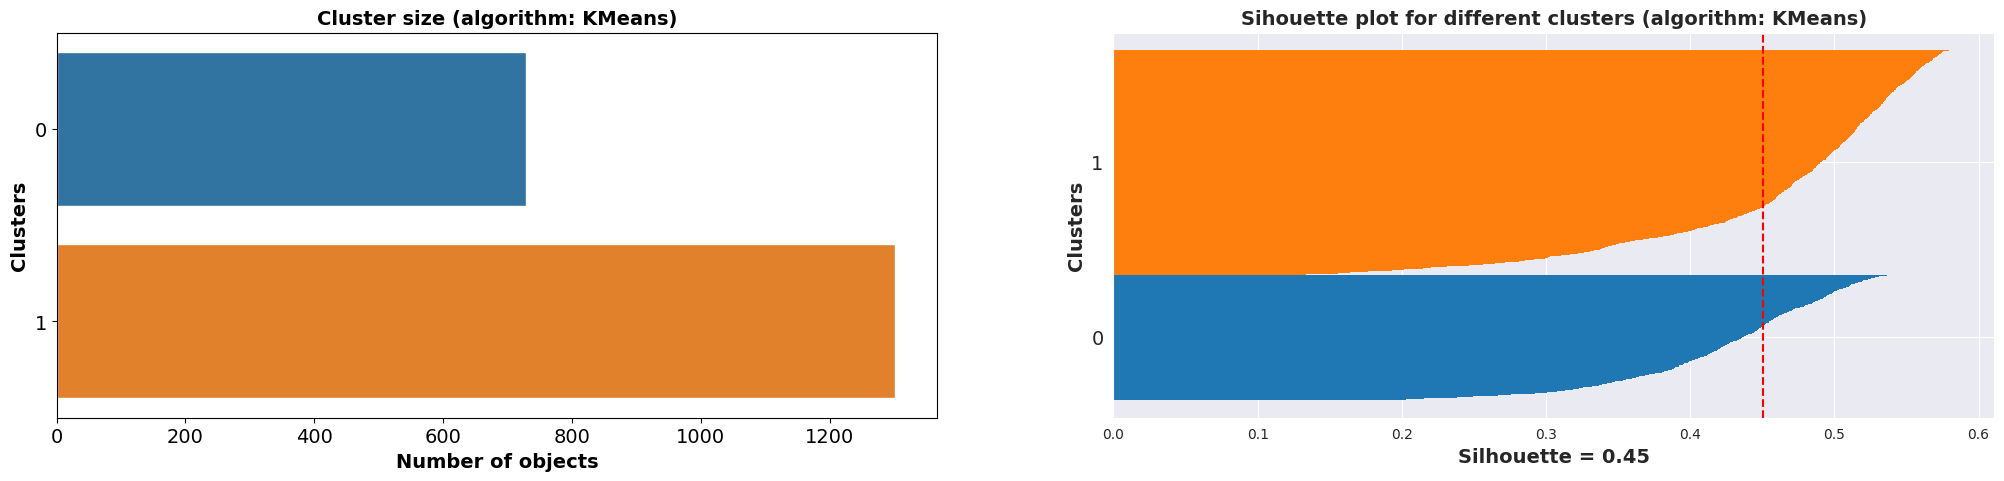

****************************************************************************************************************


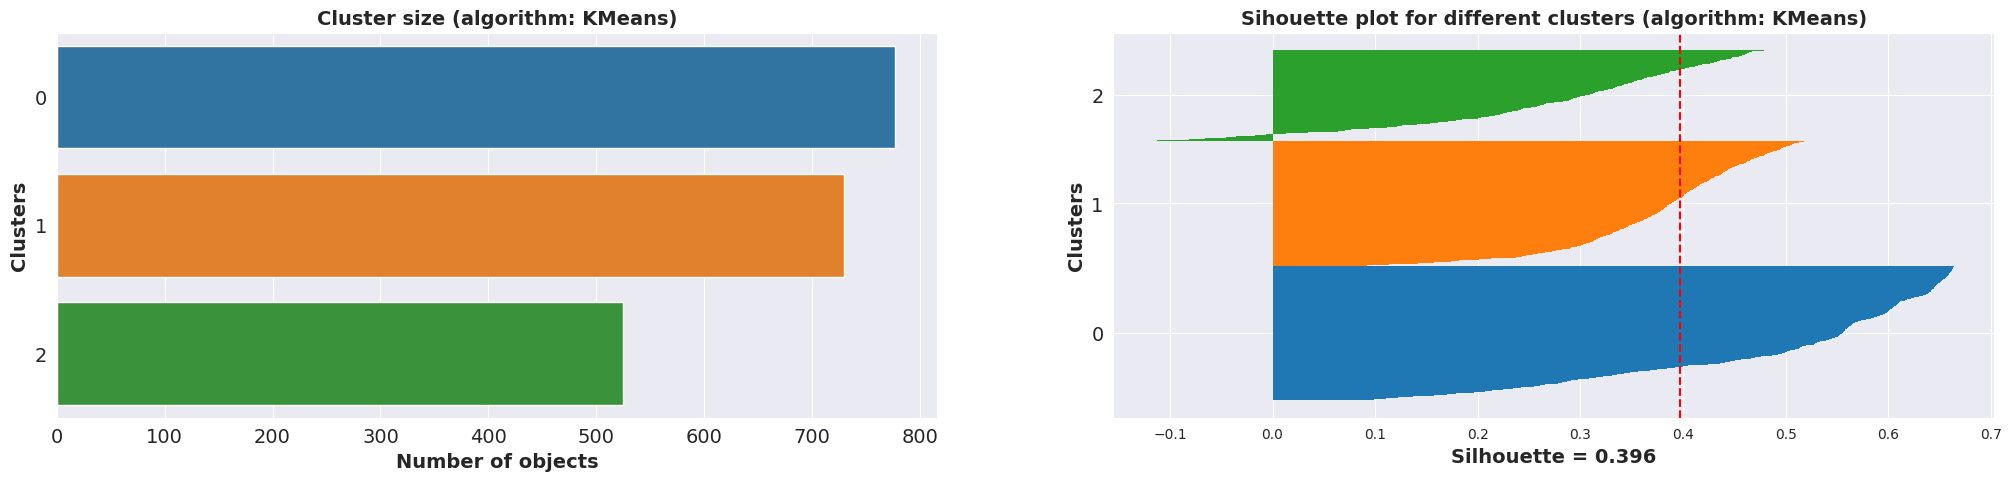

****************************************************************************************************************


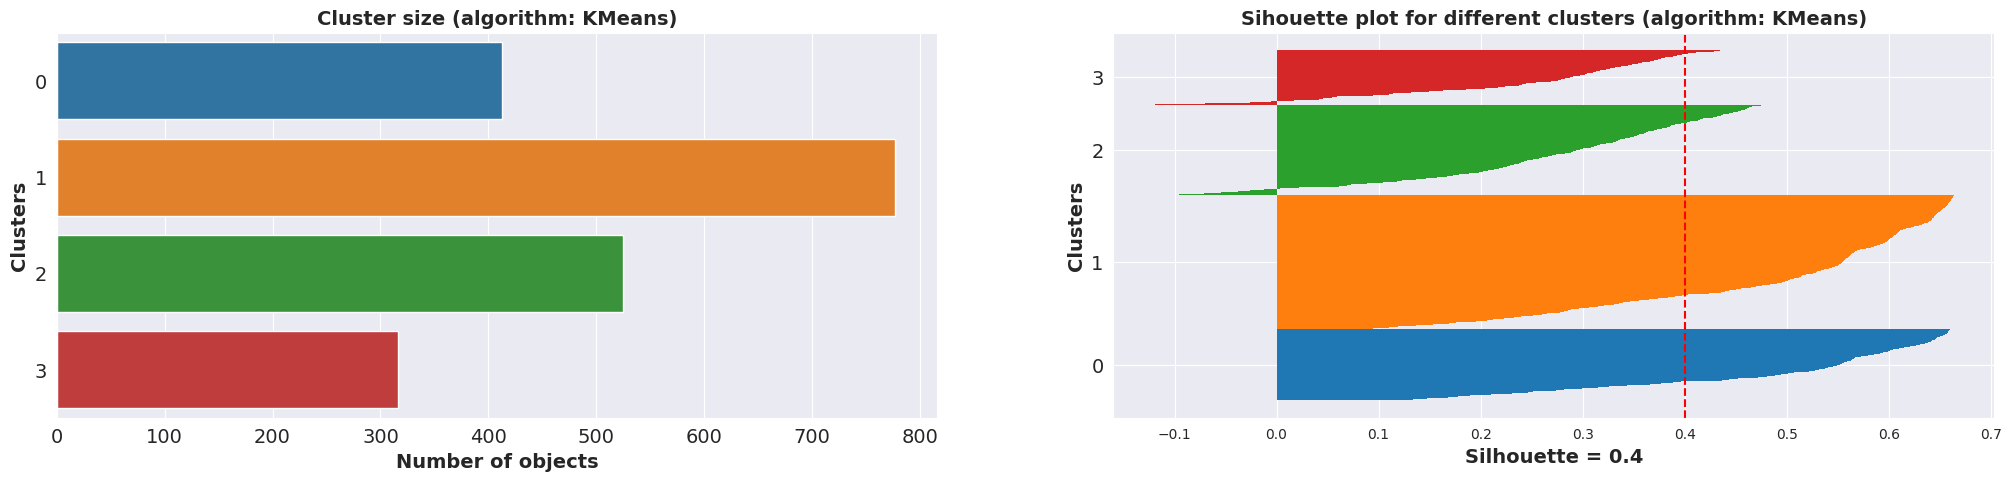

****************************************************************************************************************


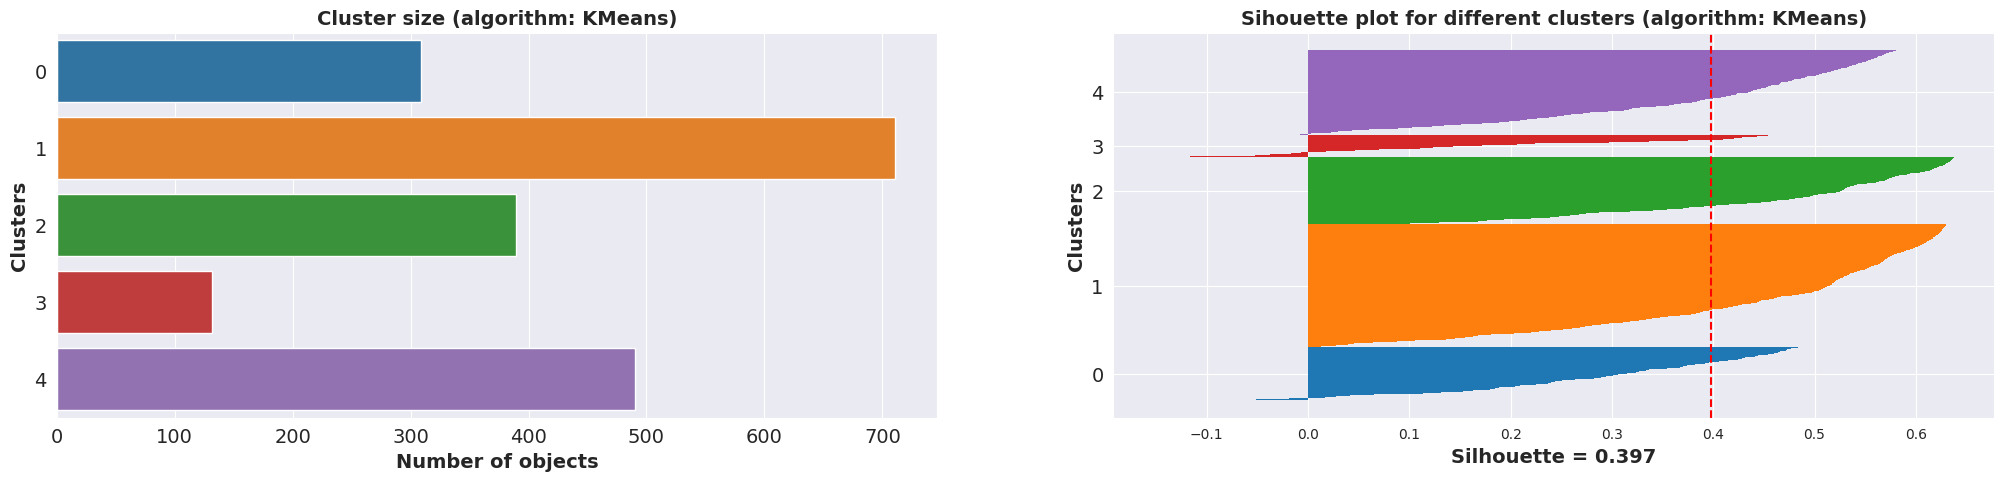

****************************************************************************************************************


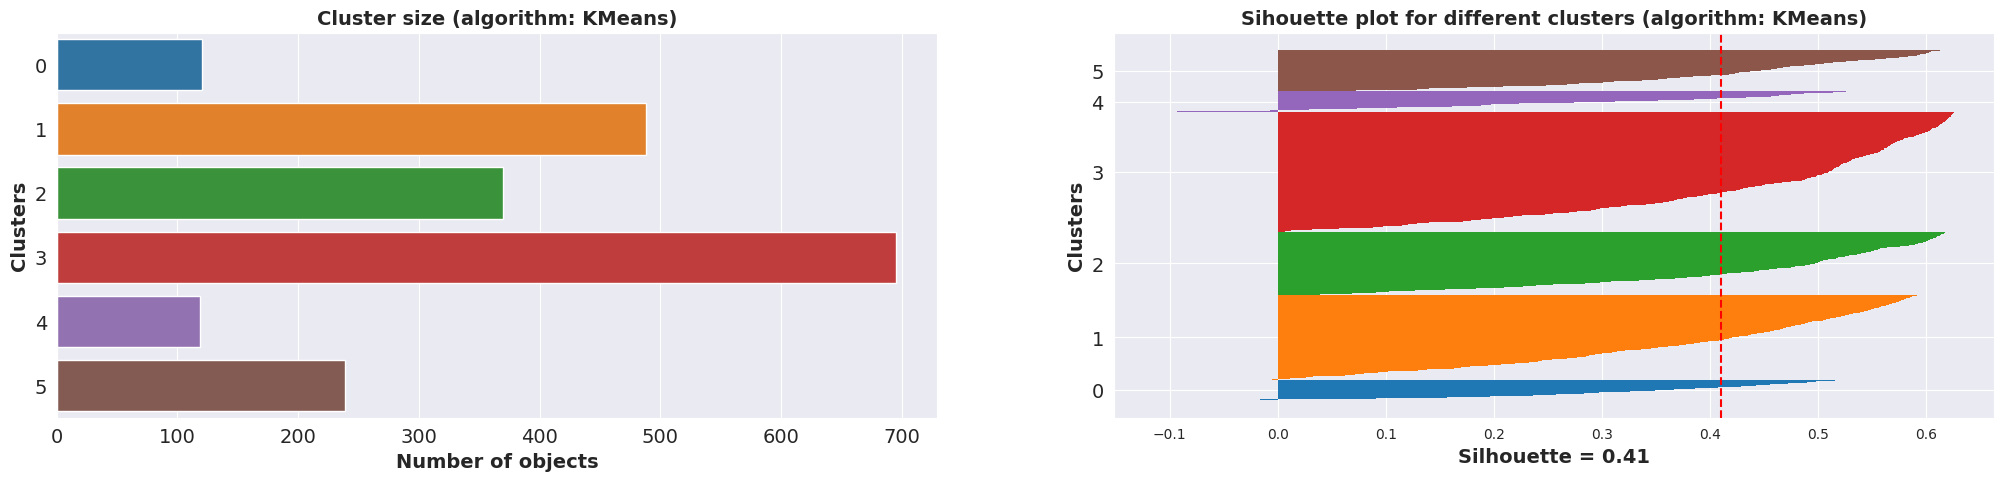

****************************************************************************************************************


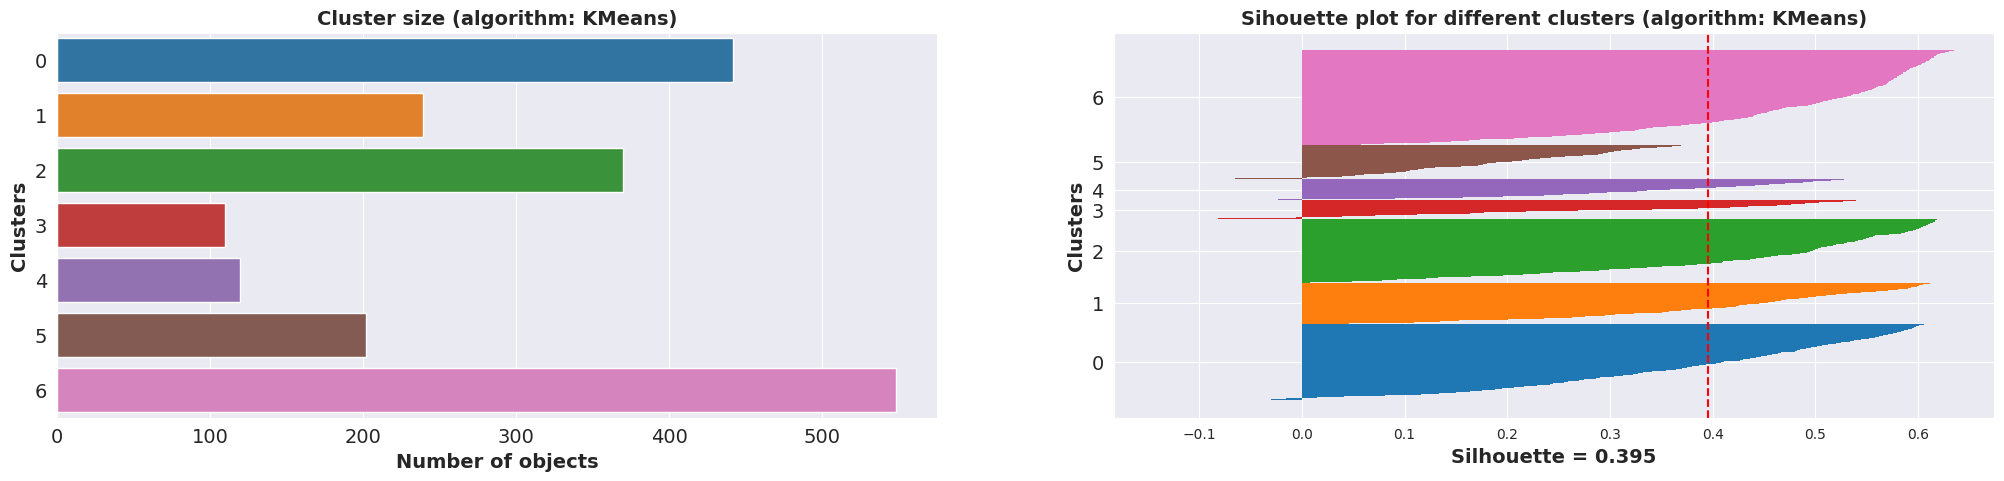

****************************************************************************************************************


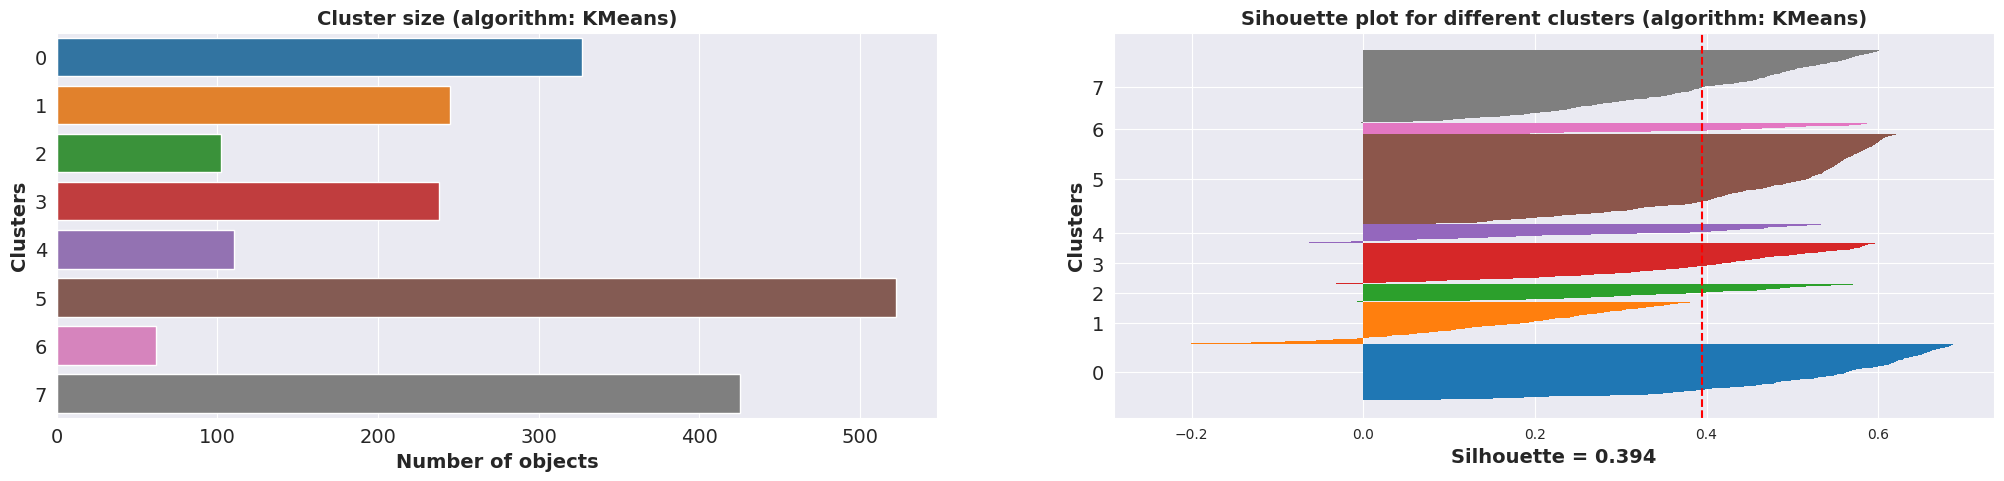

****************************************************************************************************************


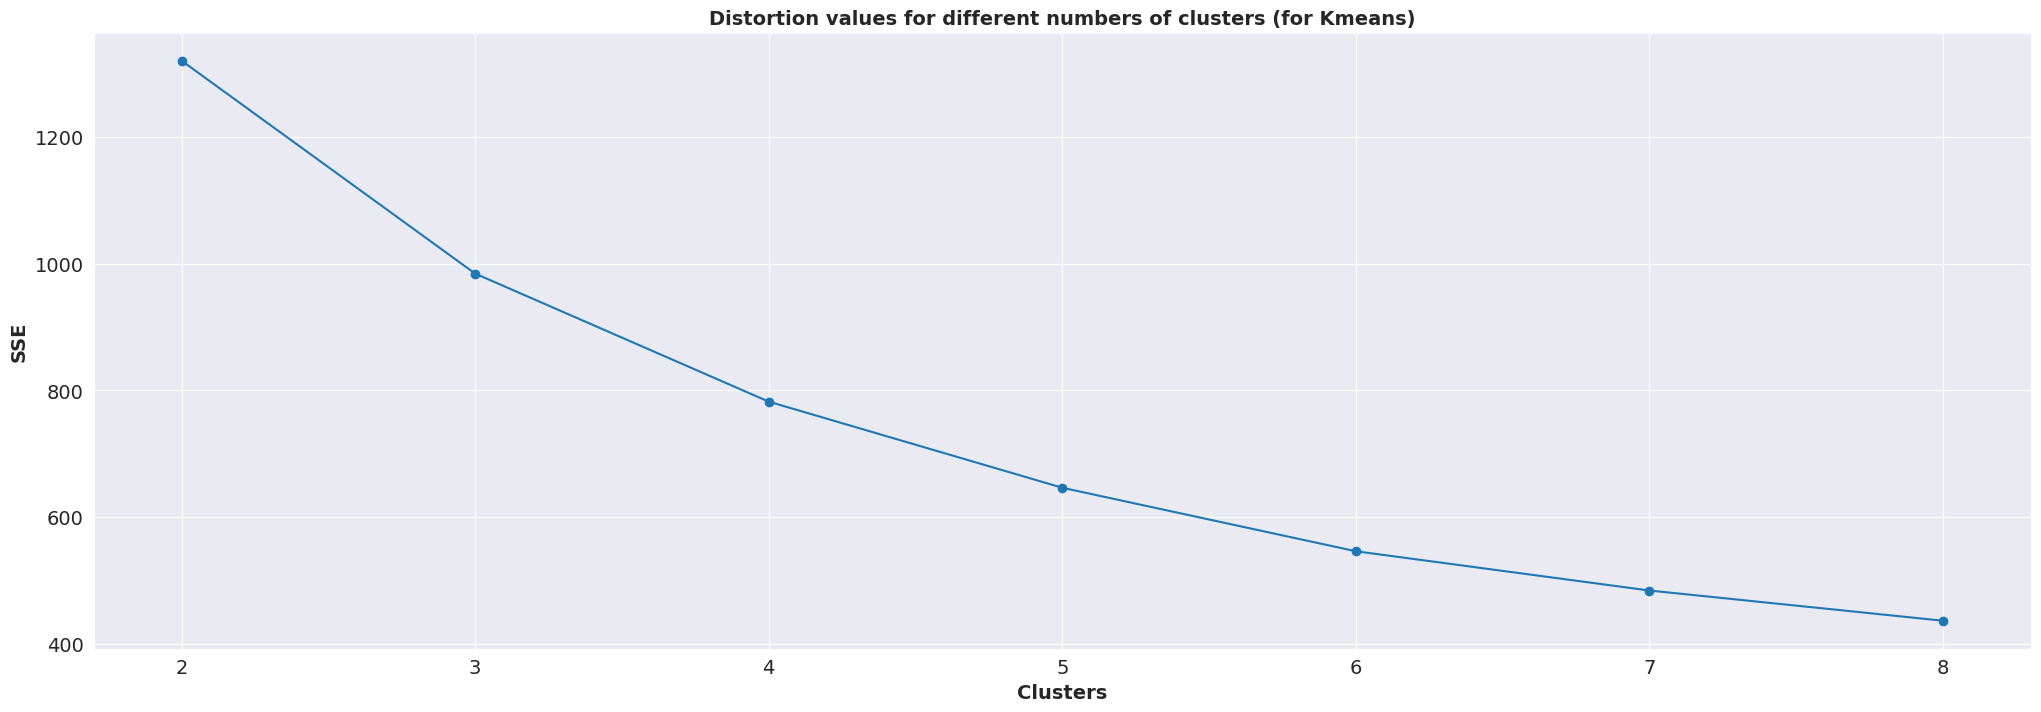

****************************************************************************************************************


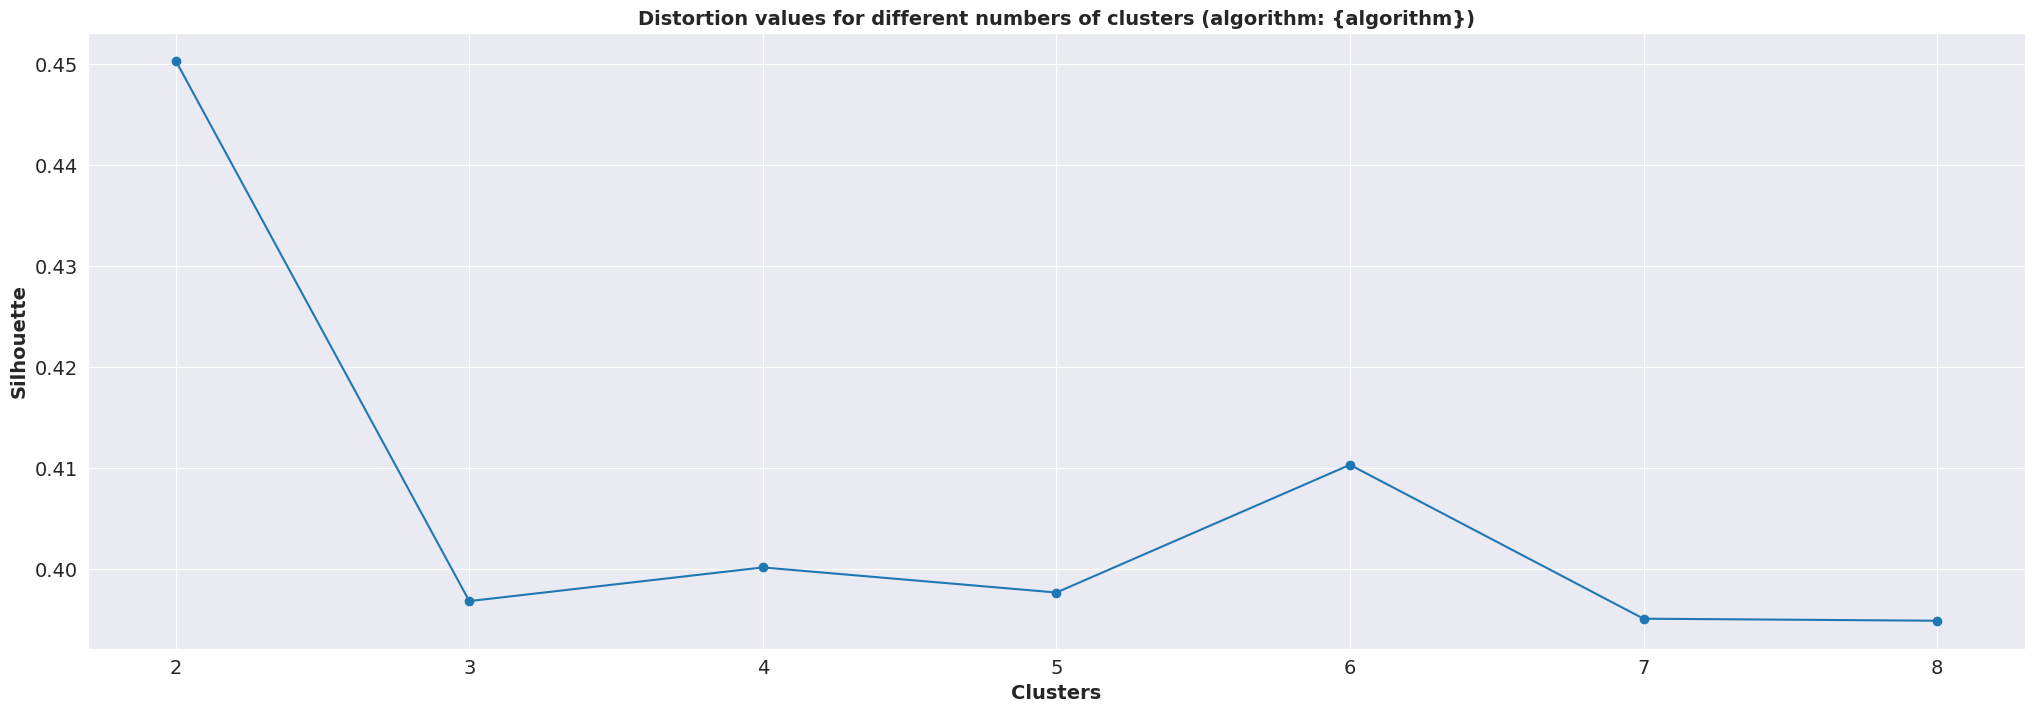

****************************************************************************************************************


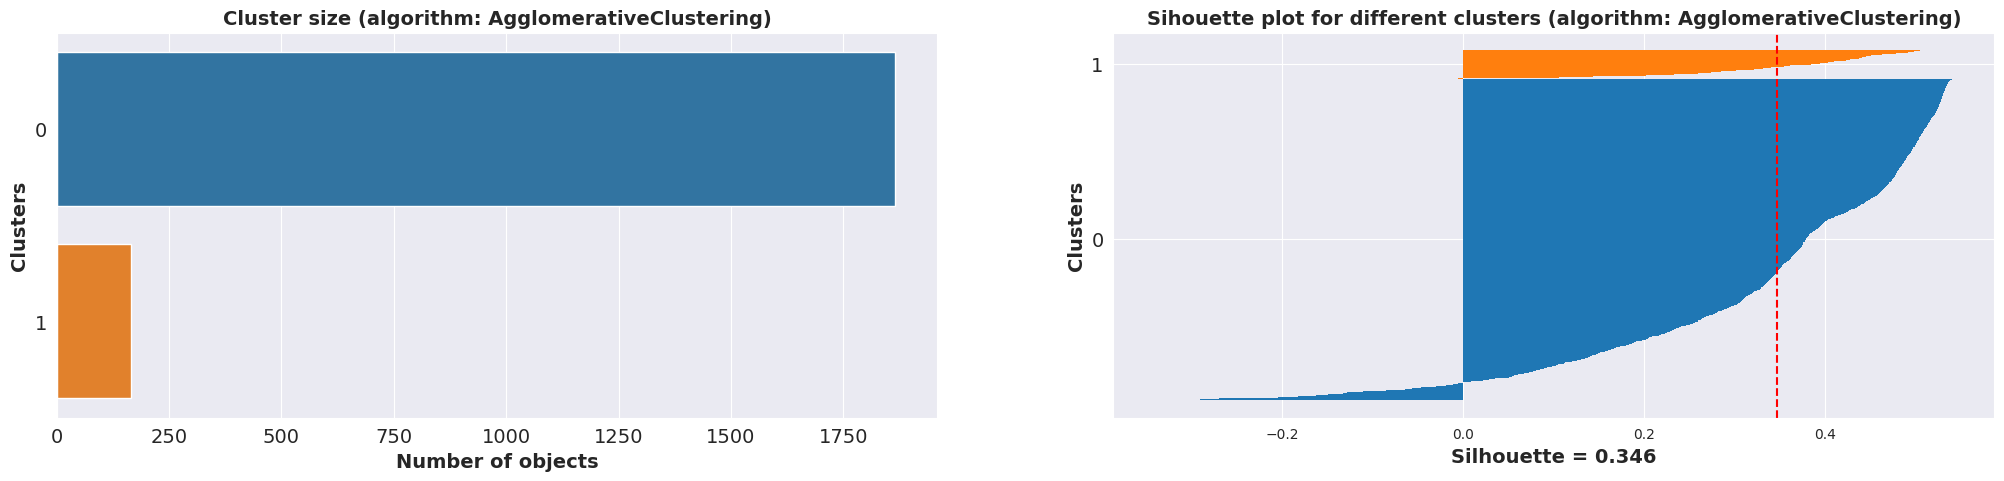

****************************************************************************************************************


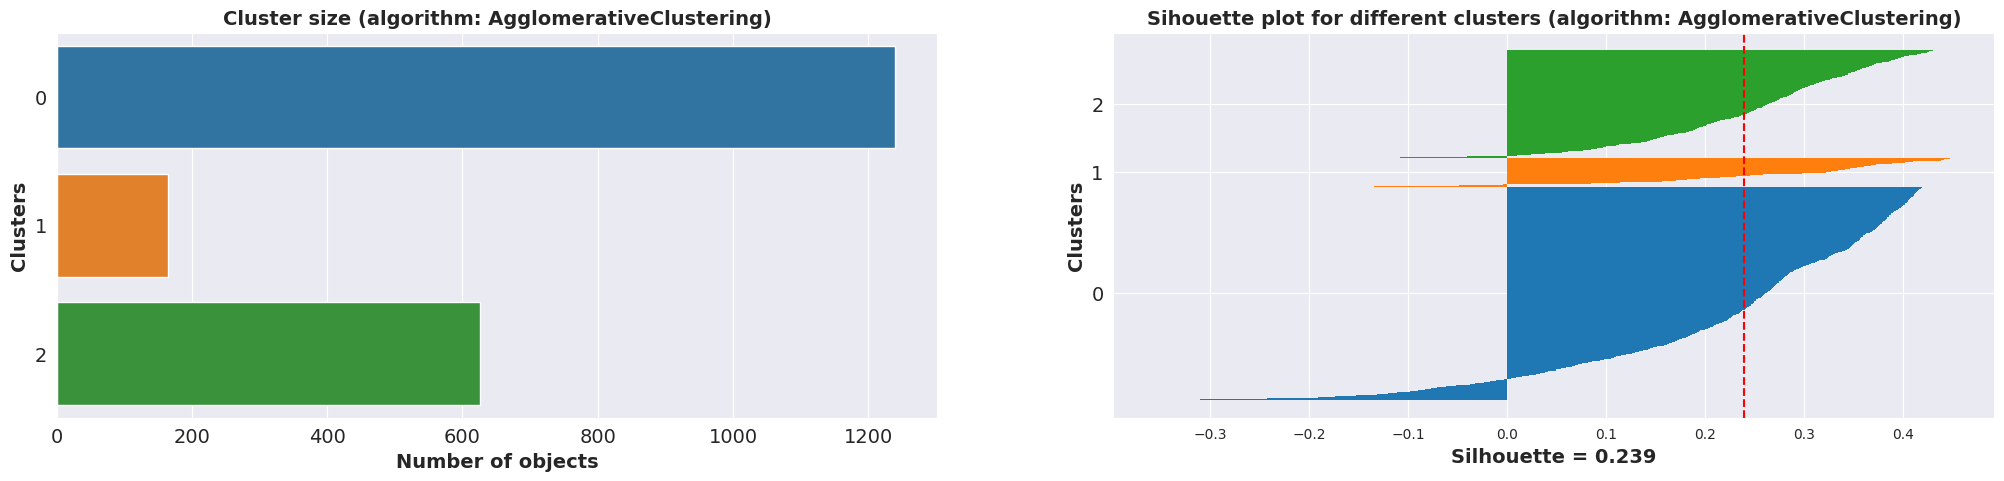

****************************************************************************************************************


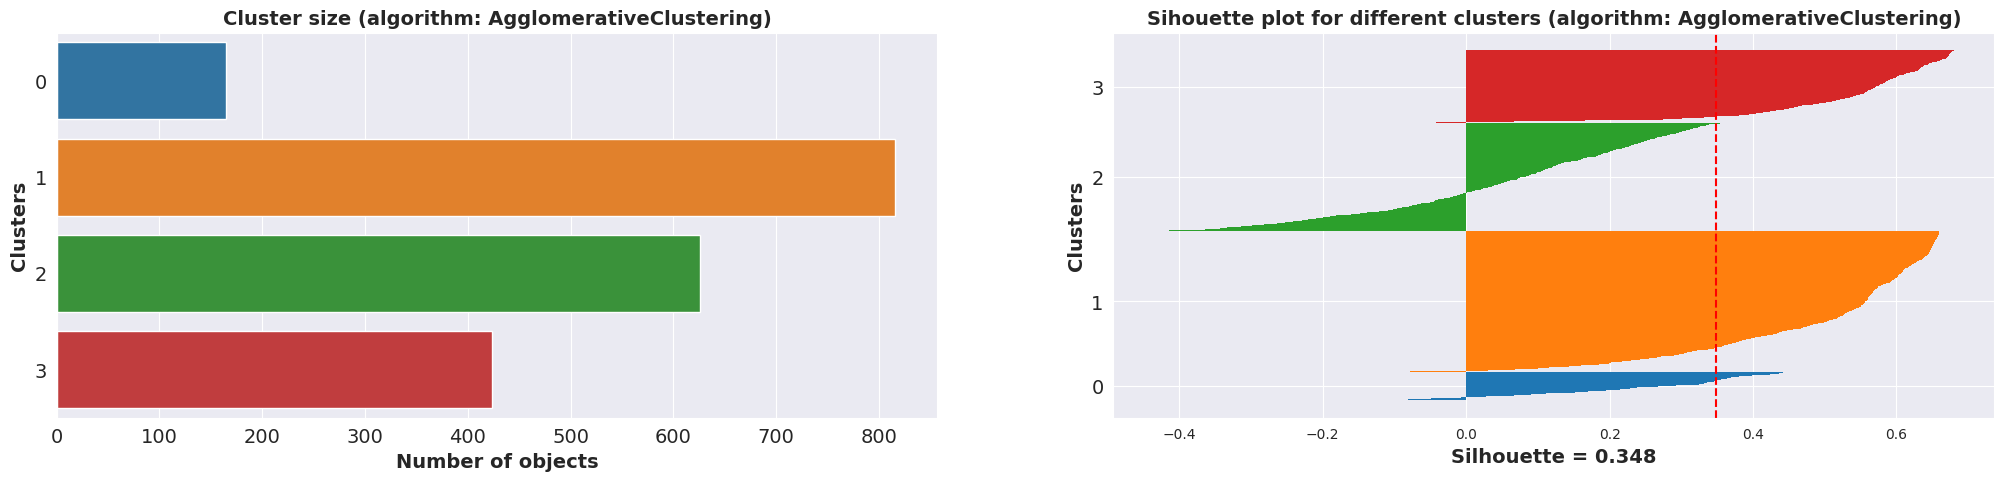

****************************************************************************************************************


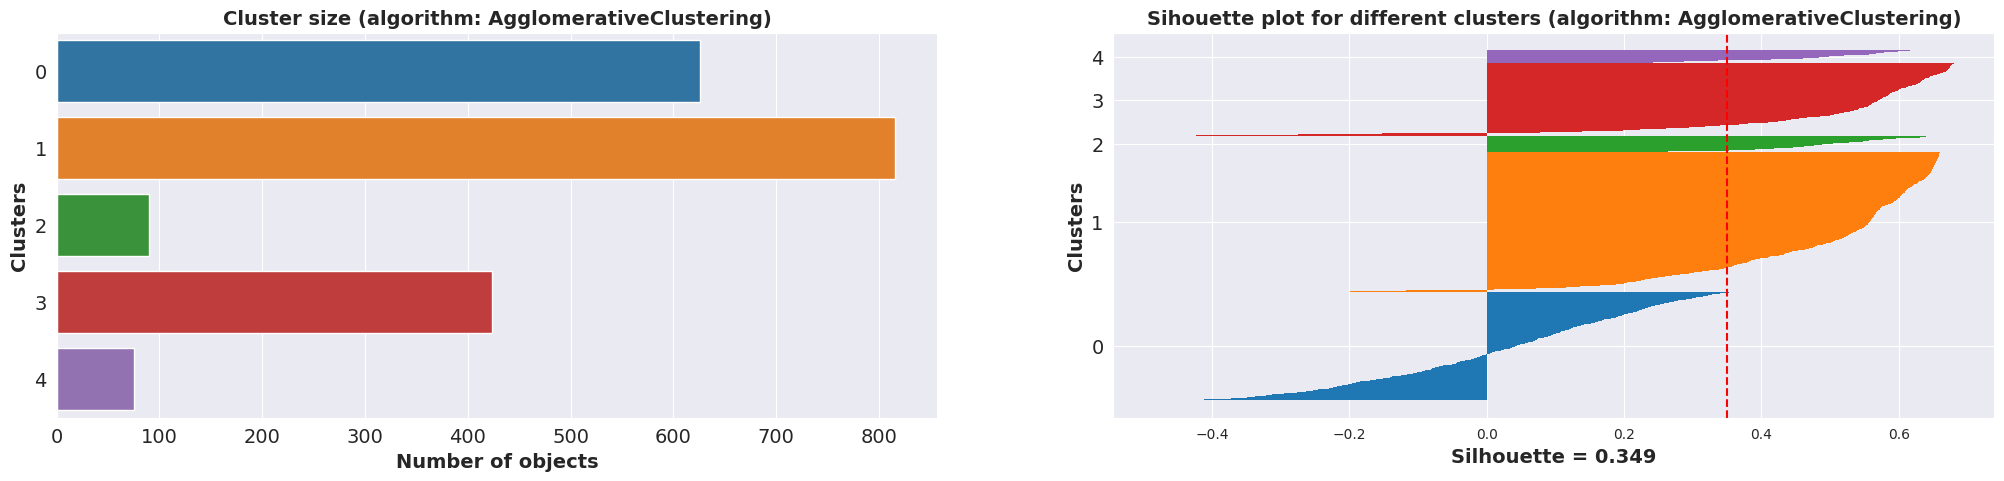

****************************************************************************************************************


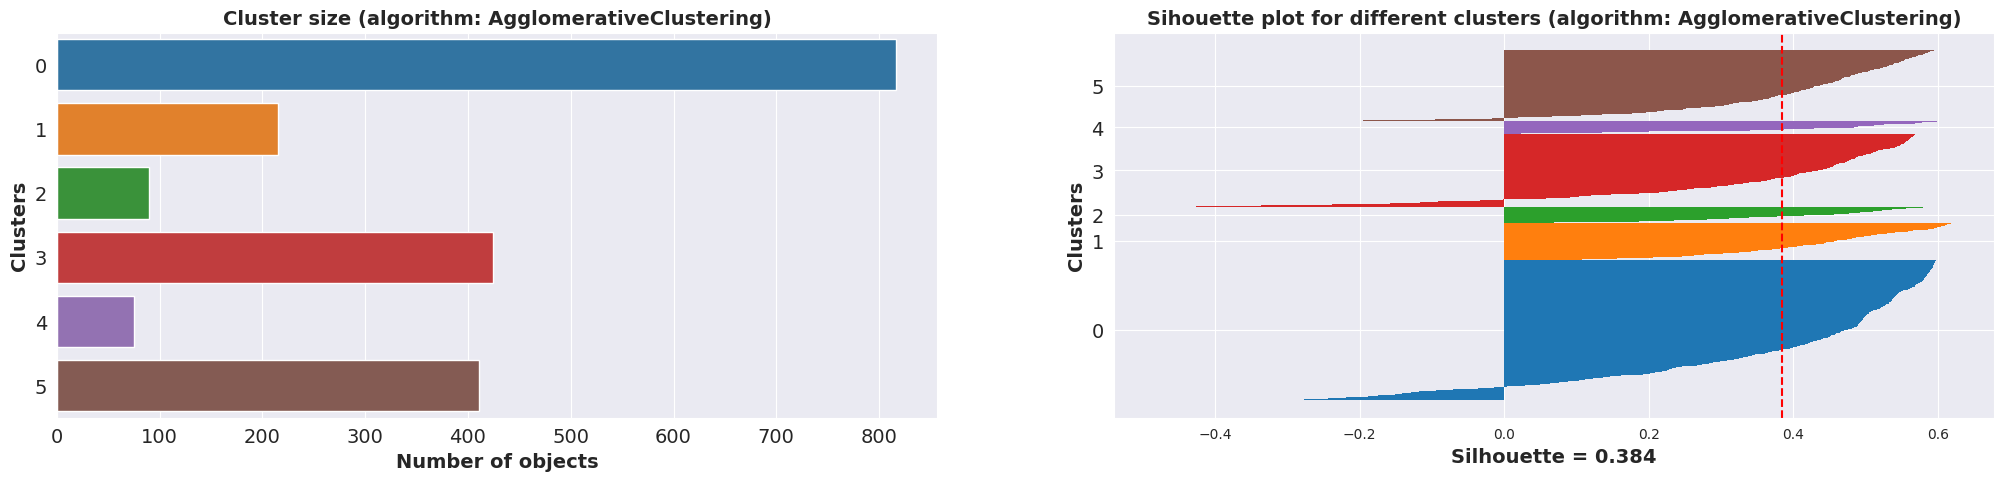

****************************************************************************************************************


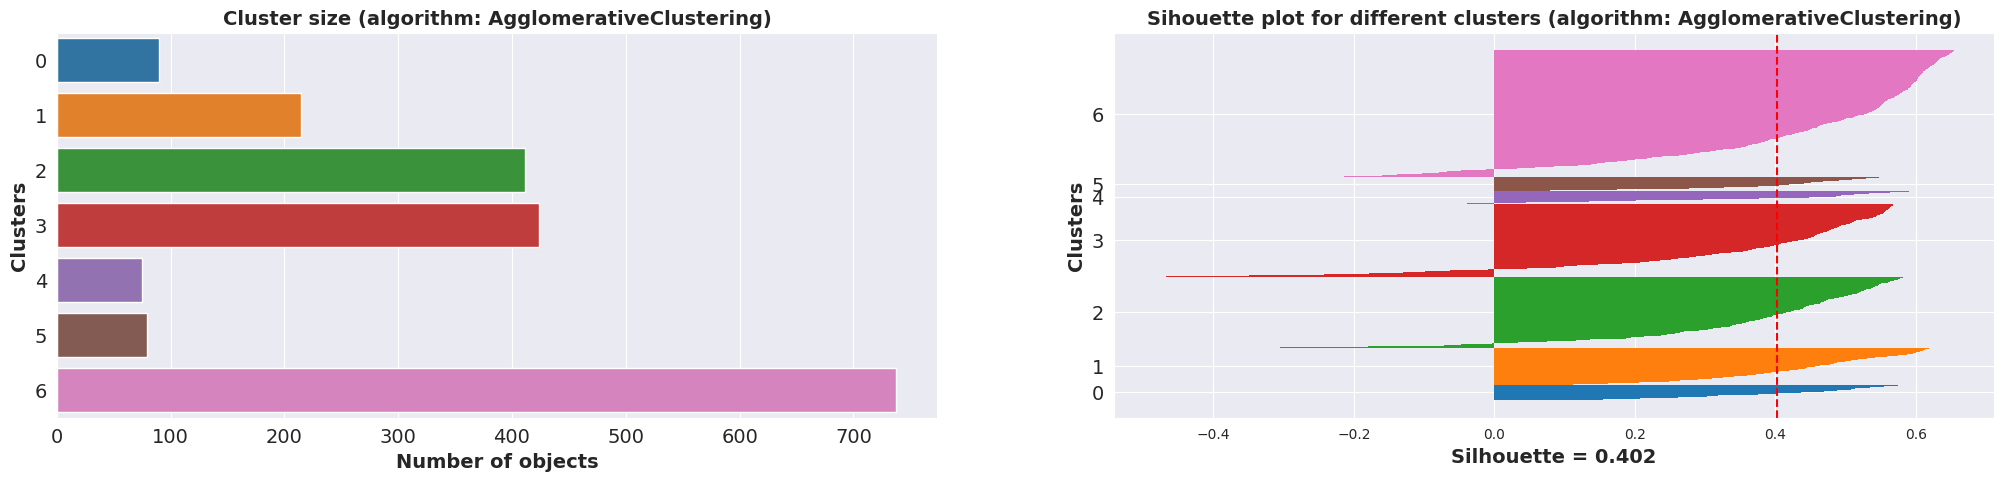

****************************************************************************************************************


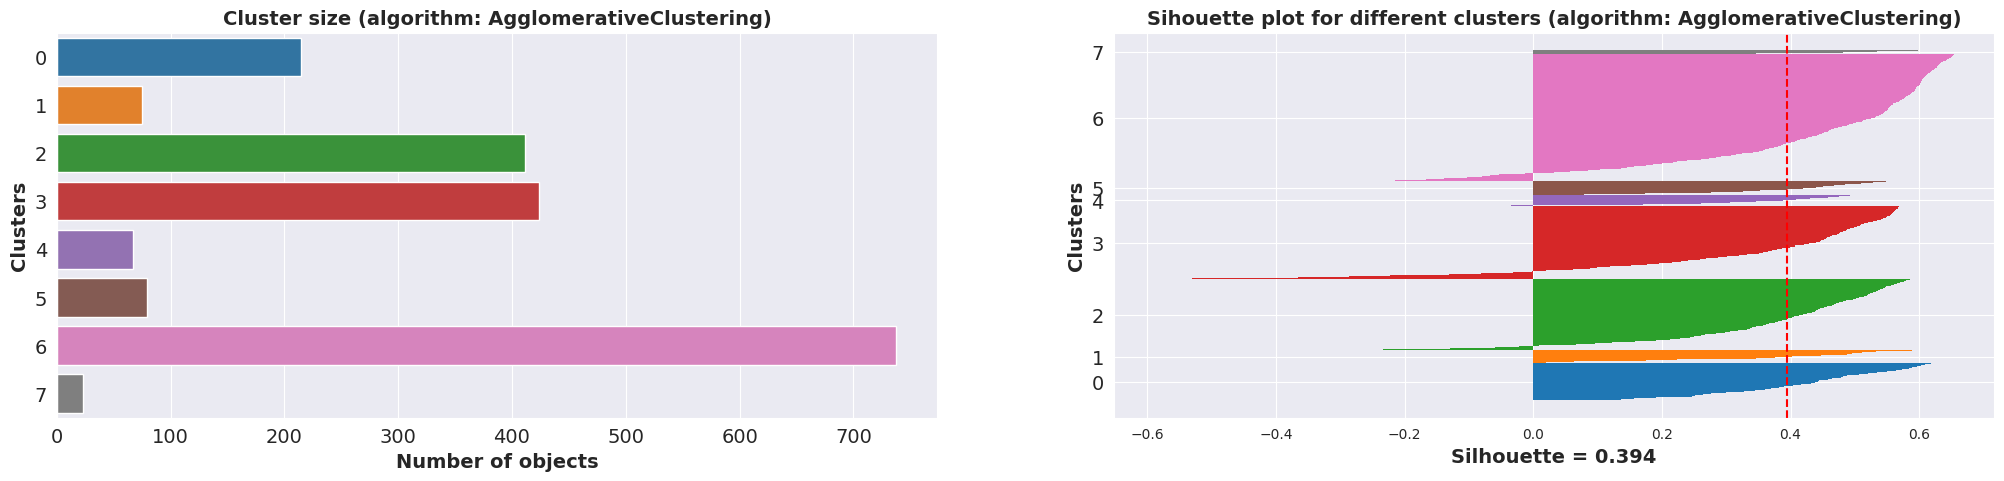

****************************************************************************************************************


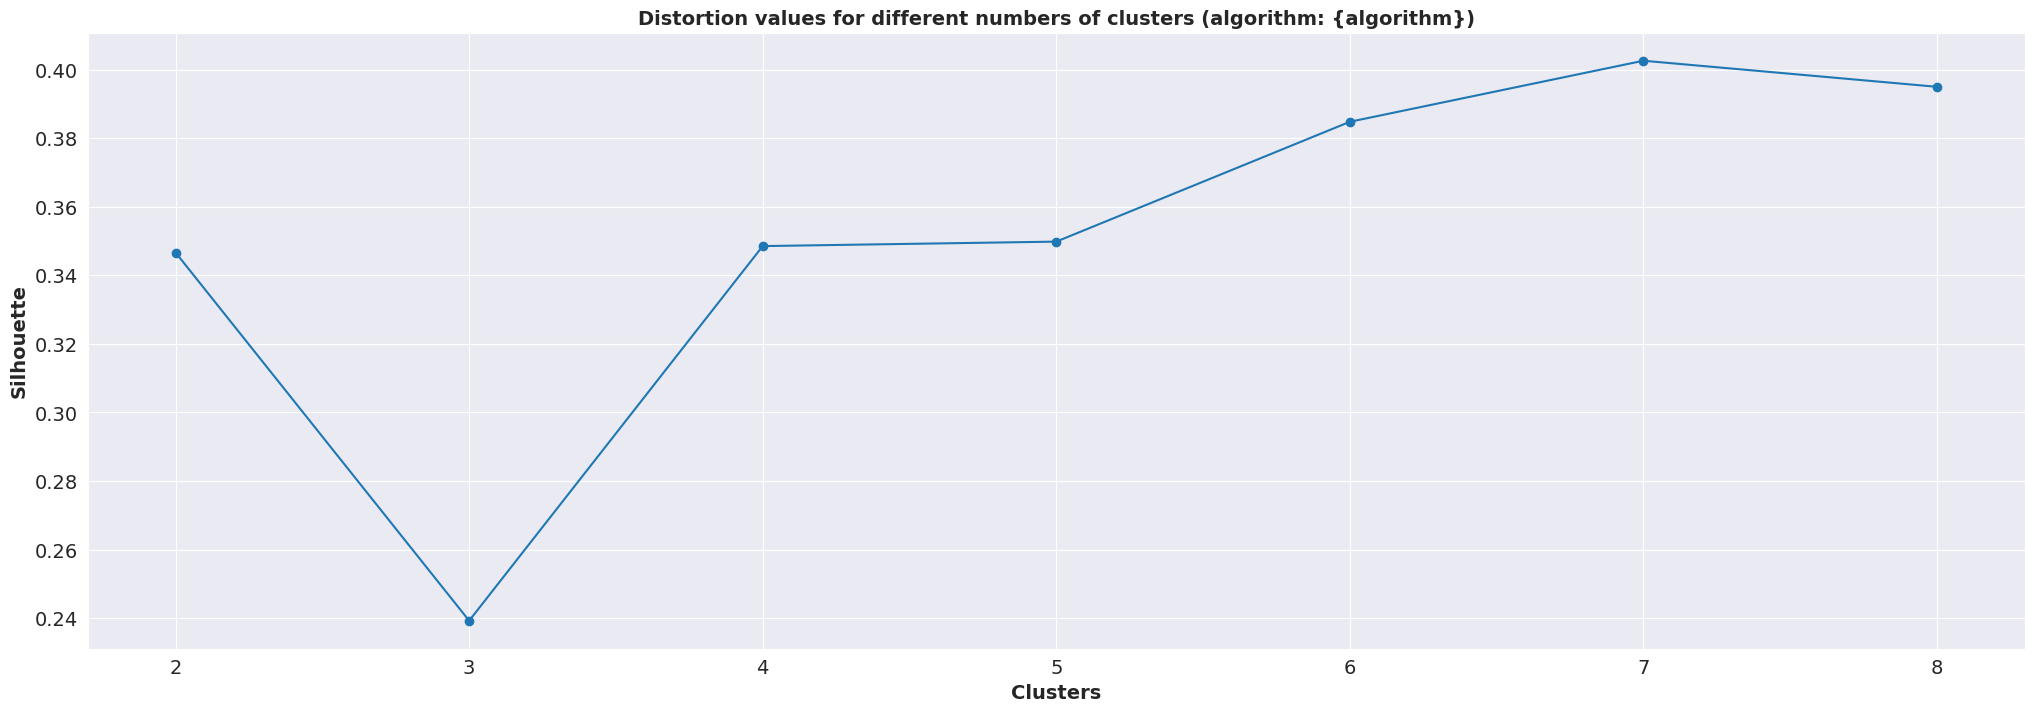

****************************************************************************************************************


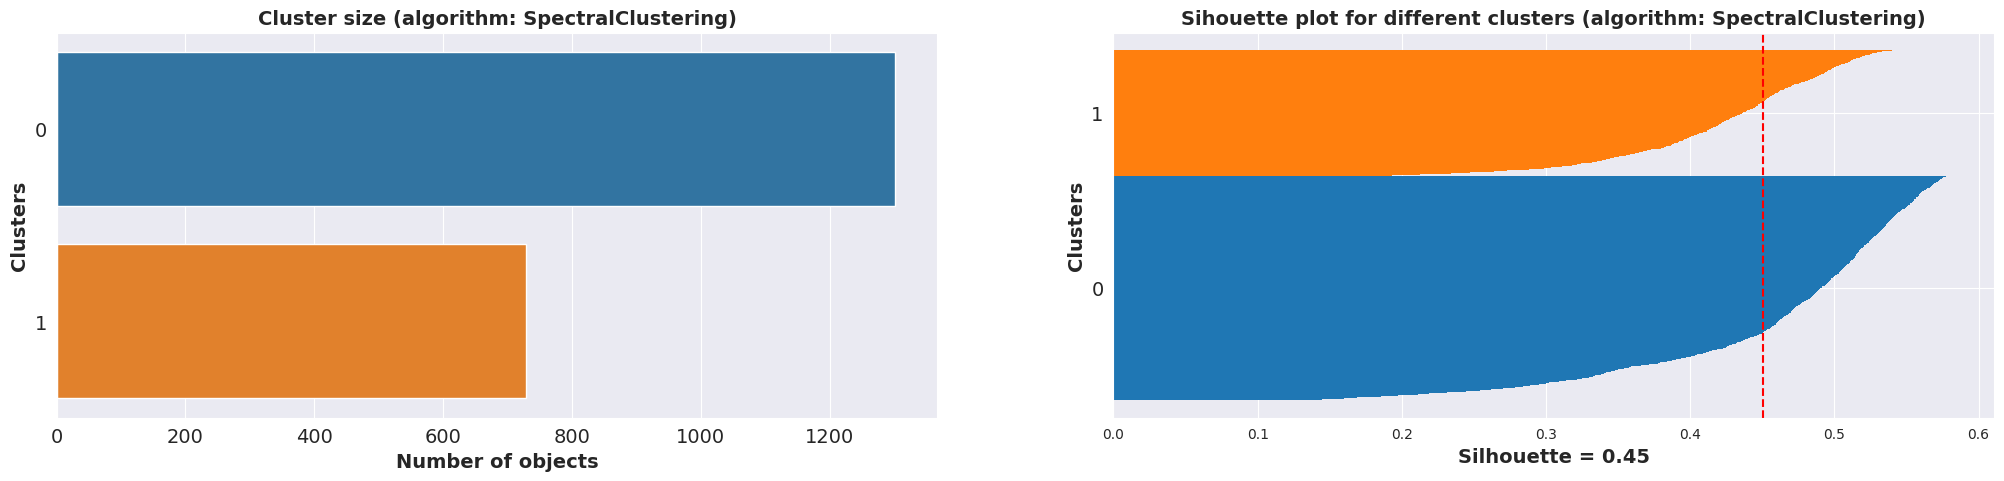

****************************************************************************************************************


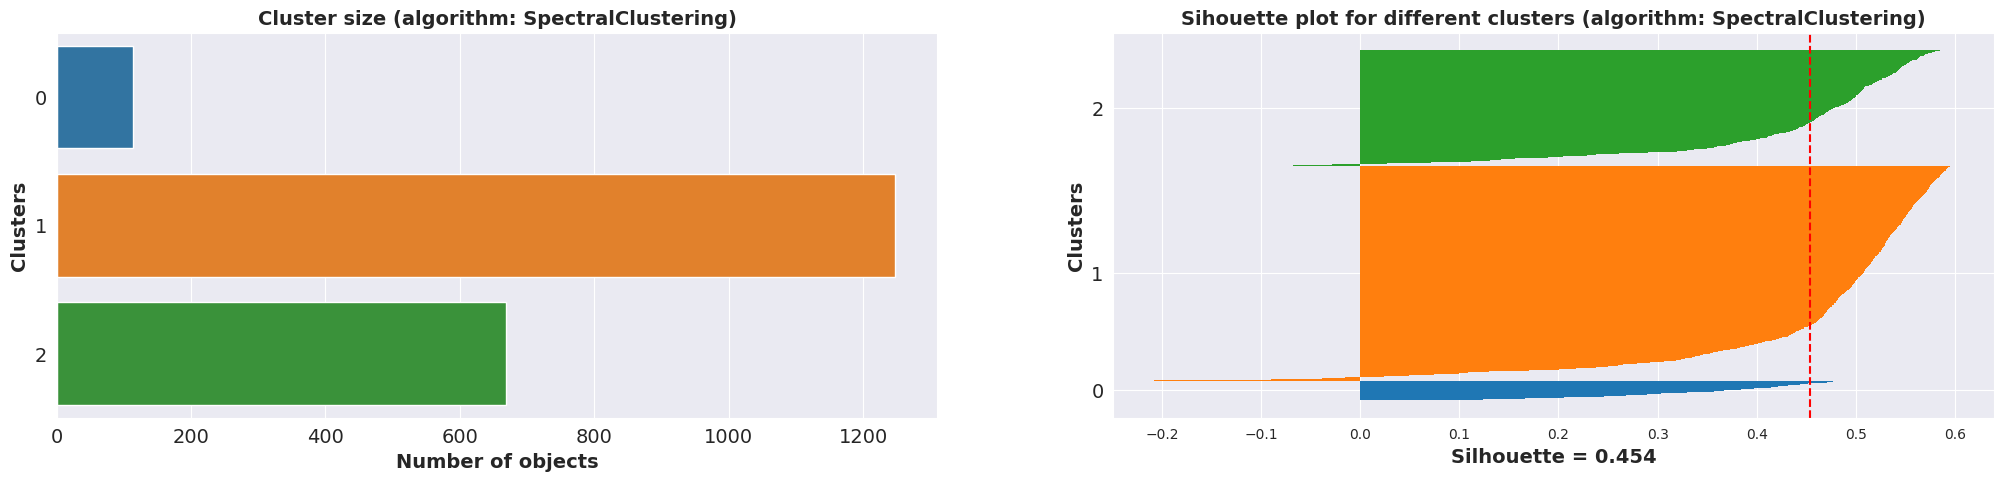

****************************************************************************************************************


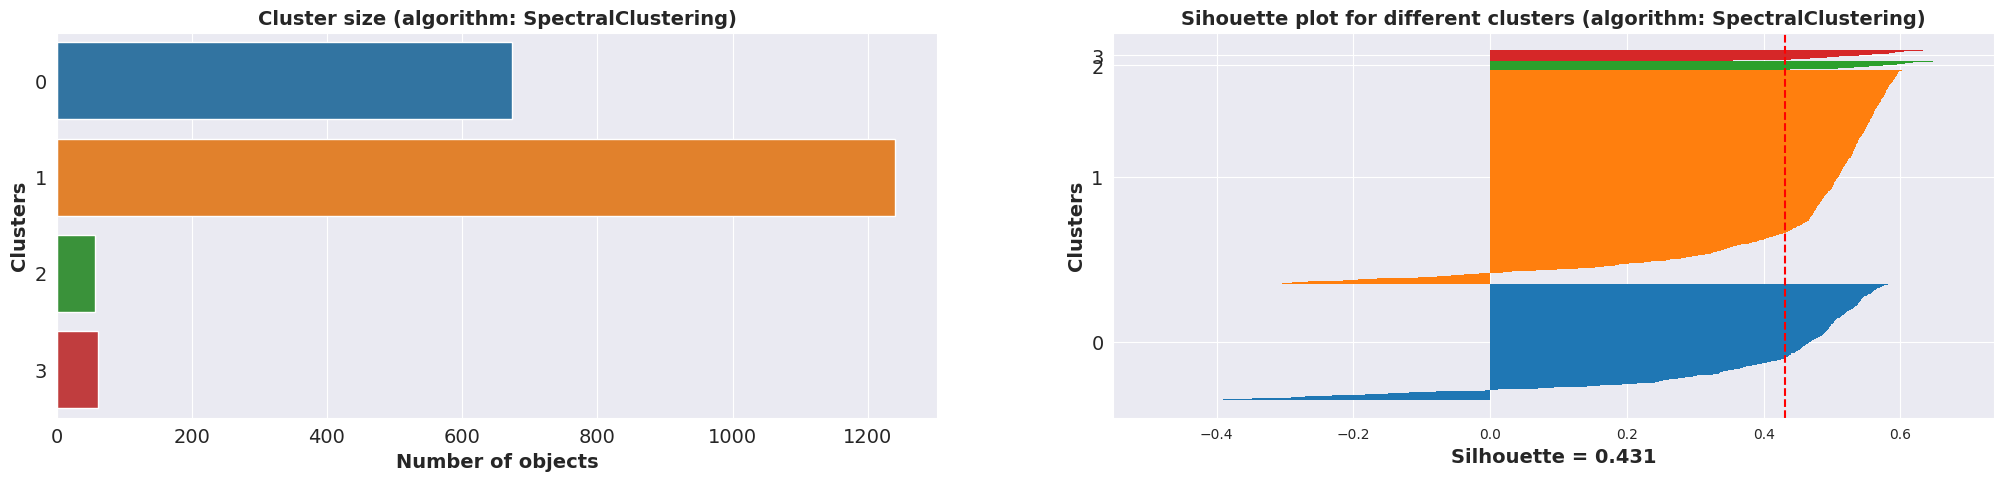

****************************************************************************************************************


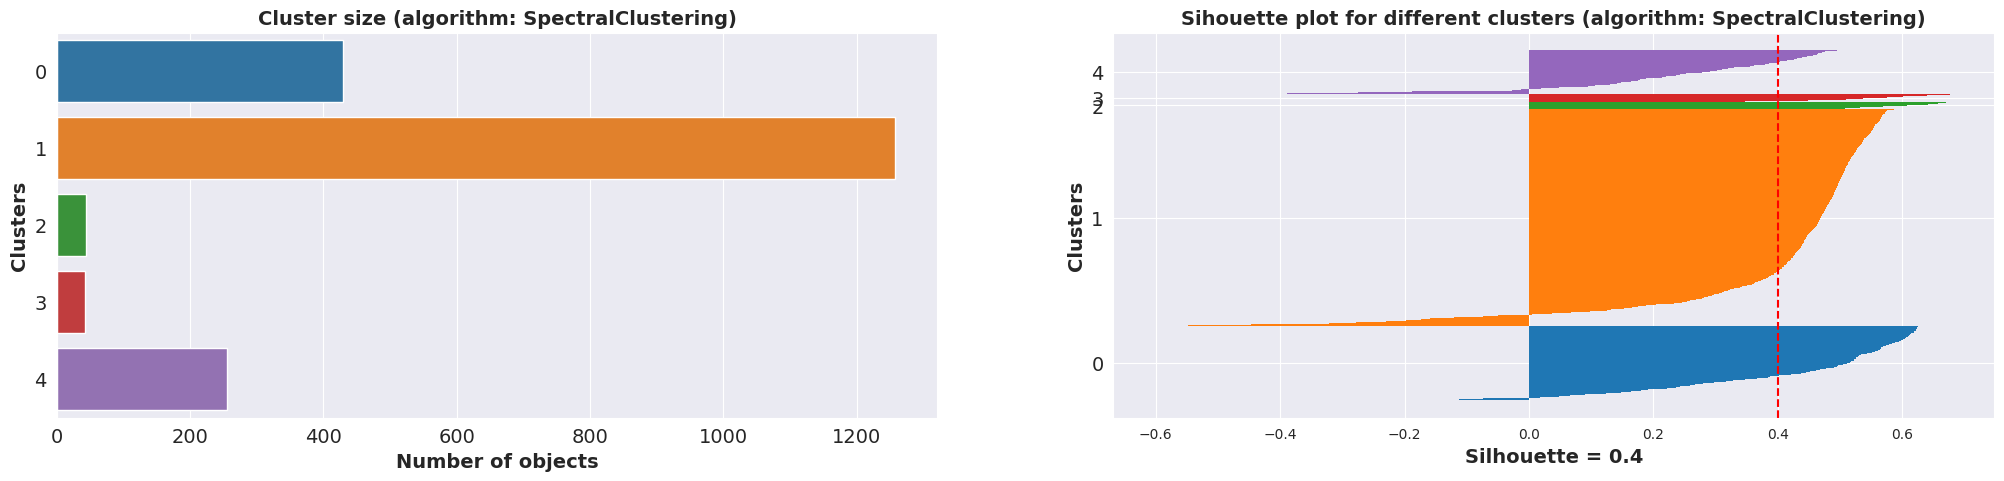

****************************************************************************************************************


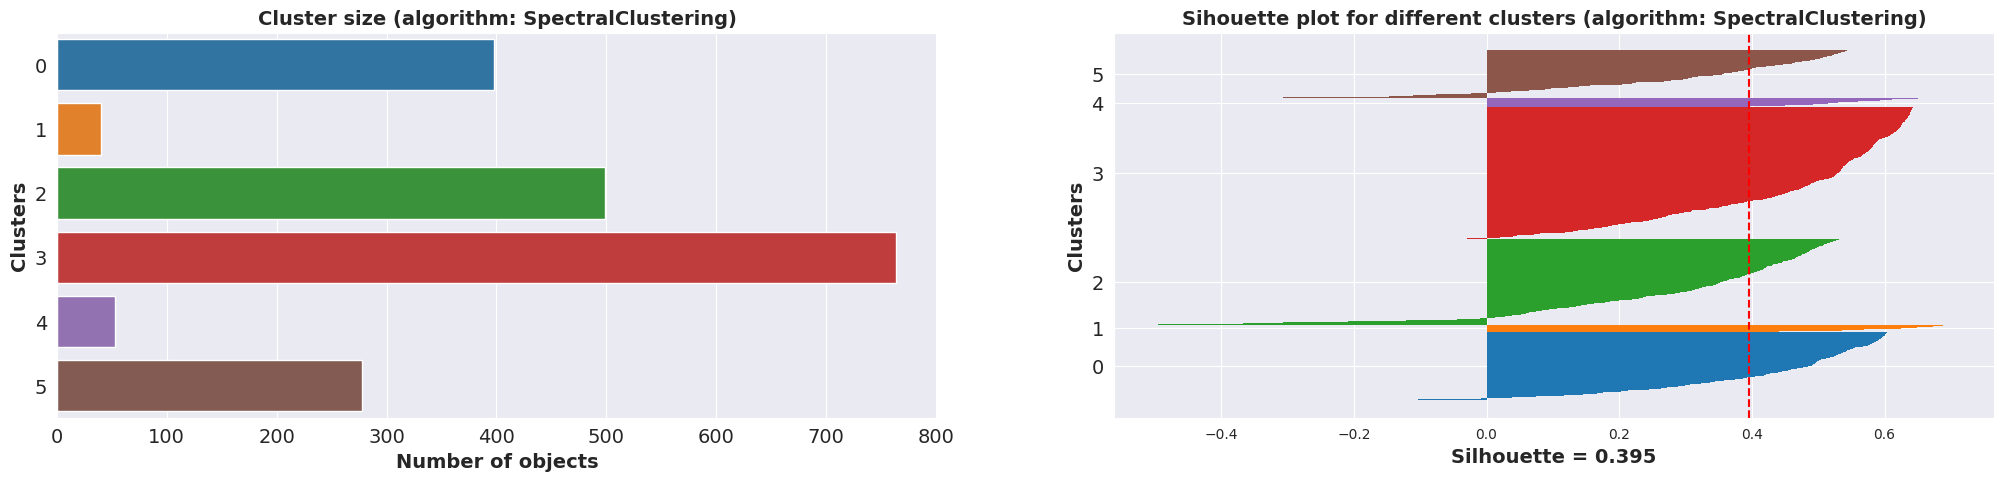

****************************************************************************************************************


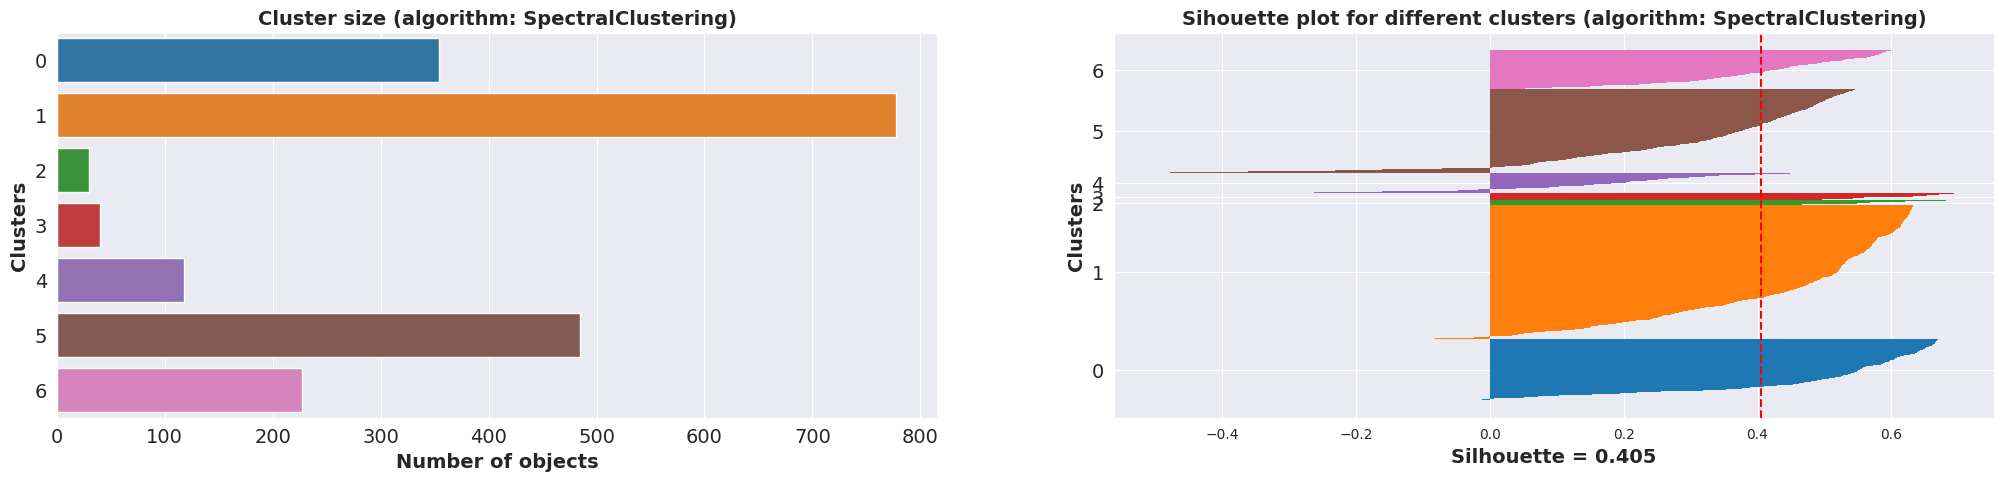

****************************************************************************************************************


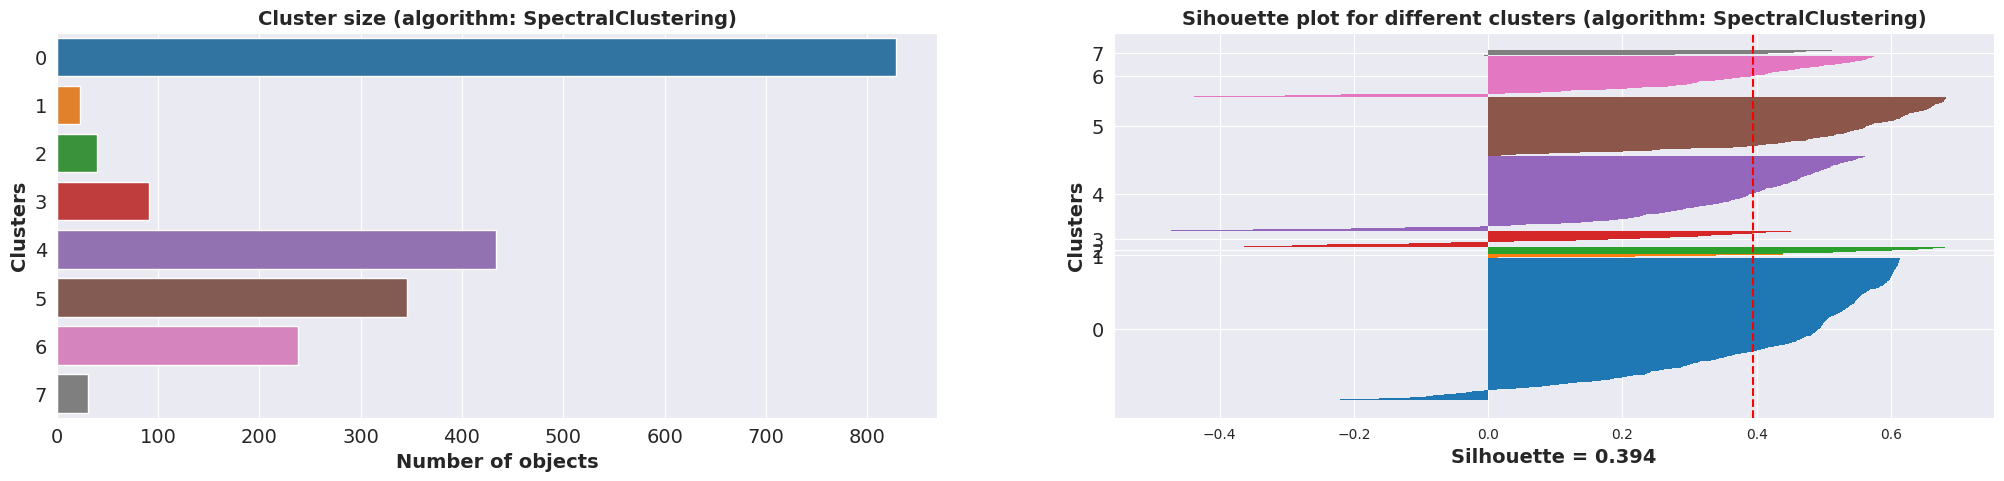

****************************************************************************************************************


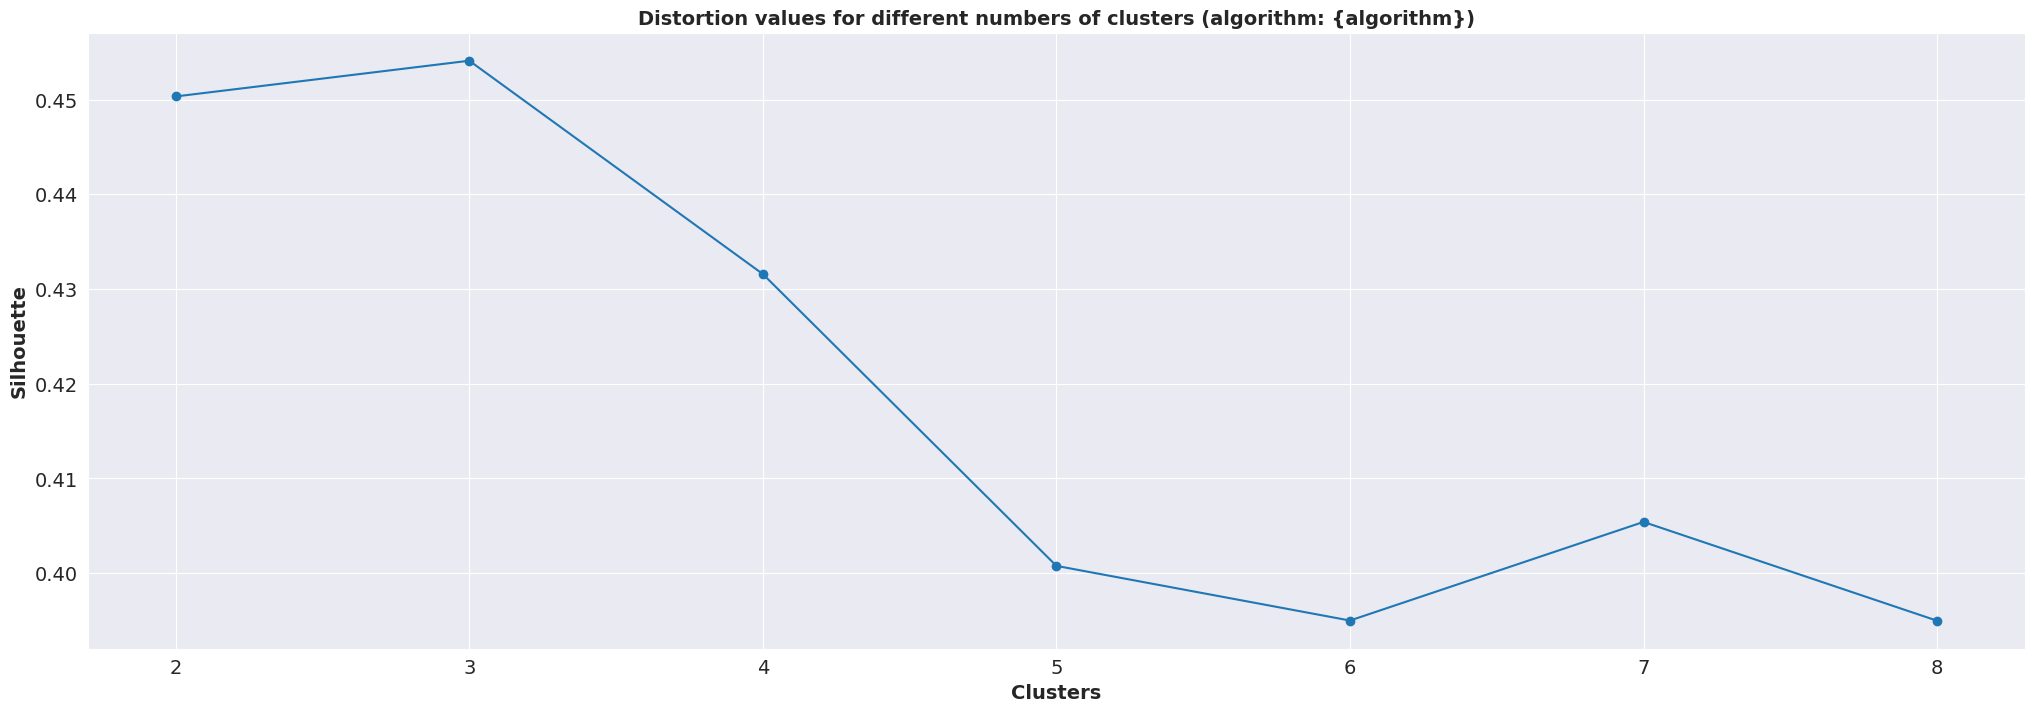

****************************************************************************************************************


In [48]:
class Clustering:
    algorithms= ['KMeans', 'AgglomerativeClustering' , 'SpectralClustering']
    min_n_clusters= 2
    max_n_clusters= 8
    kmeans_distortions= [] # Model distortions for different hyperparameters(n_clusters)

    @staticmethod
    def sse_plot():
        ''' Graphs for the SSE values (KMeans)'''
        plt.figure(figsize= (25,8))
        sns.set_style("darkgrid")
        plt.title('Distortion values for different numbers of clusters (for Kmeans)', fontsize= 14, fontweight= 'bold')
        plt.xlabel('Clusters', fontsize= 14, fontweight= 'bold')
        plt.ylabel('SSE', fontsize= 14, fontweight= 'bold')
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), Clustering.kmeans_distortions, marker= 'o')
        plt.show()

    @staticmethod
    def silhouette_result(metrics_score:list, algorithm: str):
        plt.figure(figsize= (25,8))
        sns.set_style("darkgrid")
        plt.title('Distortion values for different numbers of clusters (algorithm: {algorithm})', fontsize= 14, fontweight= 'bold')
        plt.xlabel('Clusters', fontsize= 14, fontweight= 'bold')
        plt.ylabel('Silhouette', fontsize= 14, fontweight= 'bold')
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), metrics_score, marker= 'o')
        plt.show()
        print('*'* 112)

    #Method for creating models'''
    def make_models(self, data_old: pd.DataFrame, data_modified: pd.DataFrame):
        for algorithm in Clustering.algorithms:
            metrics= [] # metrics: silhouette score
            for n_clusters in range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1):
                if algorithm == 'AgglomerativeClustering':
                    ac= AgglomerativeClustering(n_clusters= n_clusters,
                                                linkage= 'complete')
                    pred= ac.fit_predict(df_transform)
                    labels= pd.DataFrame(pred, columns = ['Labels'], index= df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.object_plot(labels, pred, algorithm)

                if algorithm == 'SpectralClustering':
                    sc= SpectralClustering (n_clusters= n_clusters)
                    pred= sc.fit_predict(df_transform)
                    labels= pd.DataFrame(pred, columns = ['Labels'], index=df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.object_plot(labels, pred, algorithm)

                if algorithm == 'KMeans':
                    kmeans= KMeans (n_clusters= n_clusters,
                                    init = "k-means++",
                                    n_init= 10,
                                    max_iter= 280,
                                    random_state=42)
                    pred= kmeans.fit_predict(df_transform)
                    labels= pd.DataFrame(pred, columns = ['Labels'], index= df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.kmeans_distortions.append(kmeans.inertia_)
                    Clustering.object_plot(labels, pred, algorithm)

            if algorithm == 'KMeans':
                Clustering.sse_plot()
                print('*' * 112)

            Clustering.silhouette_result(metrics, algorithm)

    @staticmethod
    def object_plot(labs: pd.DataFrame, predict:np.array, algorithm:str):
        # "We are building graphs of the number of objects in a cluster and the silhouette score for the model."
        # Graphs of the number of objects in a cluster and the silhouette coefficient
        cluster_group = labs.groupby('Labels').size()
        plt.figure(figsize= (25,5))
        plt.subplot(1,2,1)
        sns.set_style("darkgrid")
        plt.title(f'Cluster size (algorithm: {algorithm})', fontsize= 14, fontweight= 'bold')
        sns.barplot(x= cluster_group.values, y= list(map(str, cluster_group.index)))
        plt.xlabel('Number of objects', fontsize= 14, fontweight= 'bold')
        plt.ylabel('Clusters', fontsize= 14, fontweight= 'bold')
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)

        plt.subplot(1,2,2)
        cluster_labels= np.unique(predict)
        silhouette_vals = silhouette_samples(df_transform, predict, metric= 'euclidean')
        y_ax_lower, y_ax_upper= 0,0
        yticks= []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals= silhouette_vals[predict == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            plt.barh(range(y_ax_lower, y_ax_upper),
                     c_silhouette_vals,
                     height= 1,
                     edgecolor= 'none')

            yticks.append((y_ax_lower + y_ax_upper)/ 2)
            y_ax_lower += len(c_silhouette_vals)
        silhouette_avg= np.mean(silhouette_vals)
        plt.axvline(silhouette_avg, color= 'red', linestyle= "--")
        sns.set_style("darkgrid")
        plt.title(f'Sihouette plot for different clusters (algorithm: {algorithm})', fontsize= 14, fontweight= 'bold')
        val= float (''.join([i for i in str(silhouette_avg)][0:5]))
        plt.xlabel(f'Silhouette = {val}', fontsize= 14, fontweight= 'bold')
        plt.ylabel('Clusters', fontsize= 14, fontweight= 'bold')
        plt.yticks(yticks, cluster_labels, fontsize= 14)
        plt.show()
        print('*' * 112)

clustering= Clustering()
clustering.make_models(df, df_transform)

The elbow point is the number of clusters where the rate of decrease in distortion starts to level off. This point represents a trade-off between having a low distortion and not overfitting the data with too many clusters.

## 4. DBSCAN

In [49]:
# `eps` is the maximum distance between two samples for them to be considered as in the same neighborhood.
# `min_samples` is the minimum number of samples required in a neighborhood to consider a point as a core point.
dbscan = DBSCAN(eps=0.3, min_samples=14)
dbscan.fit(df_transform)

# Cluster labels are stored in the `labels_` attribute of the fitted DBSCAN model.
# Labels of -1 indicate noise/outliers (points that don't belong to any cluster).
df_transform['Cluster_Labels'] = dbscan.labels_

# Now you can explore the clusters and outliers in the DataFrame
print(df_transform['Cluster_Labels'].value_counts())


 0    1136
 1     551
-1     225
 2      44
 4      40
 3      21
 5      14
Name: Cluster_Labels, dtype: int64


In [50]:
from sklearn.metrics import silhouette_score

# Assuming df_scaled is your DataFrame containing the scaled data

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_transform, df_transform['Cluster_Labels'])

# Number of clusters formed (excluding the noise/outlier points)
num_clusters = len(set(df_transform['Cluster_Labels'])) - (1 if -1 in df_transform['Cluster_Labels'] else 0)

print("Number of clusters formed:", num_clusters)
print("Silhouette score:", silhouette_avg)

Number of clusters formed: 7
Silhouette score: 0.5620508854713914


In [51]:
df_transform

Education    Income   Kidhome  Teenhome  Cluster_Labels
0     -0.371961  0.560498 -0.477526  0.113900               0
1      1.107713  0.160312  0.605336  0.442399              -1
2      0.710366 -0.765331 -0.036786 -0.587393               1
3      0.780374 -0.666091 -0.127592 -0.058033               1
4     -0.481047  0.387620 -0.420116 -0.171609               0
...         ...       ...       ...       ...             ...
2026  -0.549118  0.035864 -0.180789  0.358571               0
2027   0.755061 -0.837730 -0.008336  0.501680               1
2028  -0.545647 -0.359700  0.037294  0.159856               0
2029   0.786604 -0.727201  0.057147  0.073216               1
2030   0.889270 -0.476565 -0.058450  0.126441               1

[2031 rows x 5 columns]

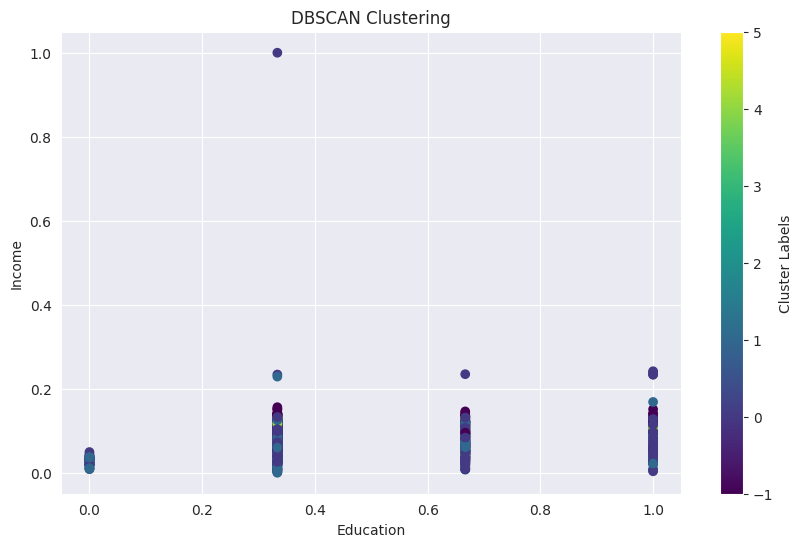

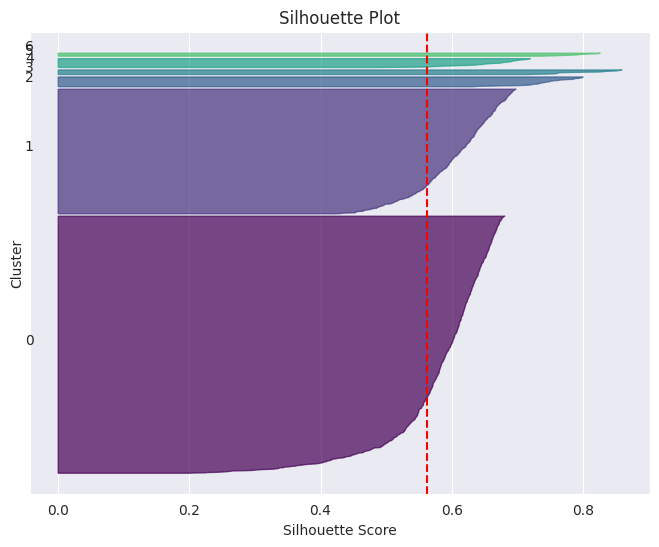

Number of clusters formed: 7
Silhouette score: 0.5620508854713914


In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# Assuming df_trans is your DataFrame containing the scaled data

# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled['Education'], df_scaled['Income'], c=df_transform['Cluster_Labels'], cmap='viridis')
plt.xlabel('Education')
plt.ylabel('Income')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster Labels')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_transform, df_transform['Cluster_Labels'])

# Calculate silhouette scores for each data point
silhouette_values = silhouette_samples(df_transform, df_transform['Cluster_Labels'])

# Create a silhouette plot
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(num_clusters):
    cluster_silhouette_values = silhouette_values[df_transform['Cluster_Labels'] == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    color = plt.cm.viridis(float(i) / num_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color='red', linestyle='--')
plt.yticks([])
plt.ylabel('Cluster')
plt.xlabel('Silhouette Score')
plt.title('Silhouette Plot')
plt.show()

print("Number of clusters formed:", num_clusters)
print("Silhouette score:", silhouette_avg)


# Now let's build graphs of the main characteristics for features int | float for the best models (since we got object labels)

In [53]:
best_model = DBSCAN(eps=0.3, min_samples=14)
labels = pd.DataFrame(best_model.fit_predict(df_transform), columns=['Cluster_Labels'], index=df_scaled.index)
df = pd.concat([df_scaled, labels], axis=1)

In [54]:
df_transform.head()

Education    Income   Kidhome  Teenhome  Cluster_Labels
0  -0.371961  0.560498 -0.477526  0.113900               0
1   1.107713  0.160312  0.605336  0.442399              -1
2   0.710366 -0.765331 -0.036786 -0.587393               1
3   0.780374 -0.666091 -0.127592 -0.058033               1
4  -0.481047  0.387620 -0.420116 -0.171609               0

In [55]:
object_cols= ['Education', 'Kidhome', 'Teenhome', 'Family_Size', 'Alone', 'Partner']
num_cols= ['Income', 'Recency', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
            'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases',
            'NumWebVisitsMonth', 'Age', 'Years_Since_Registration',
            'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases']


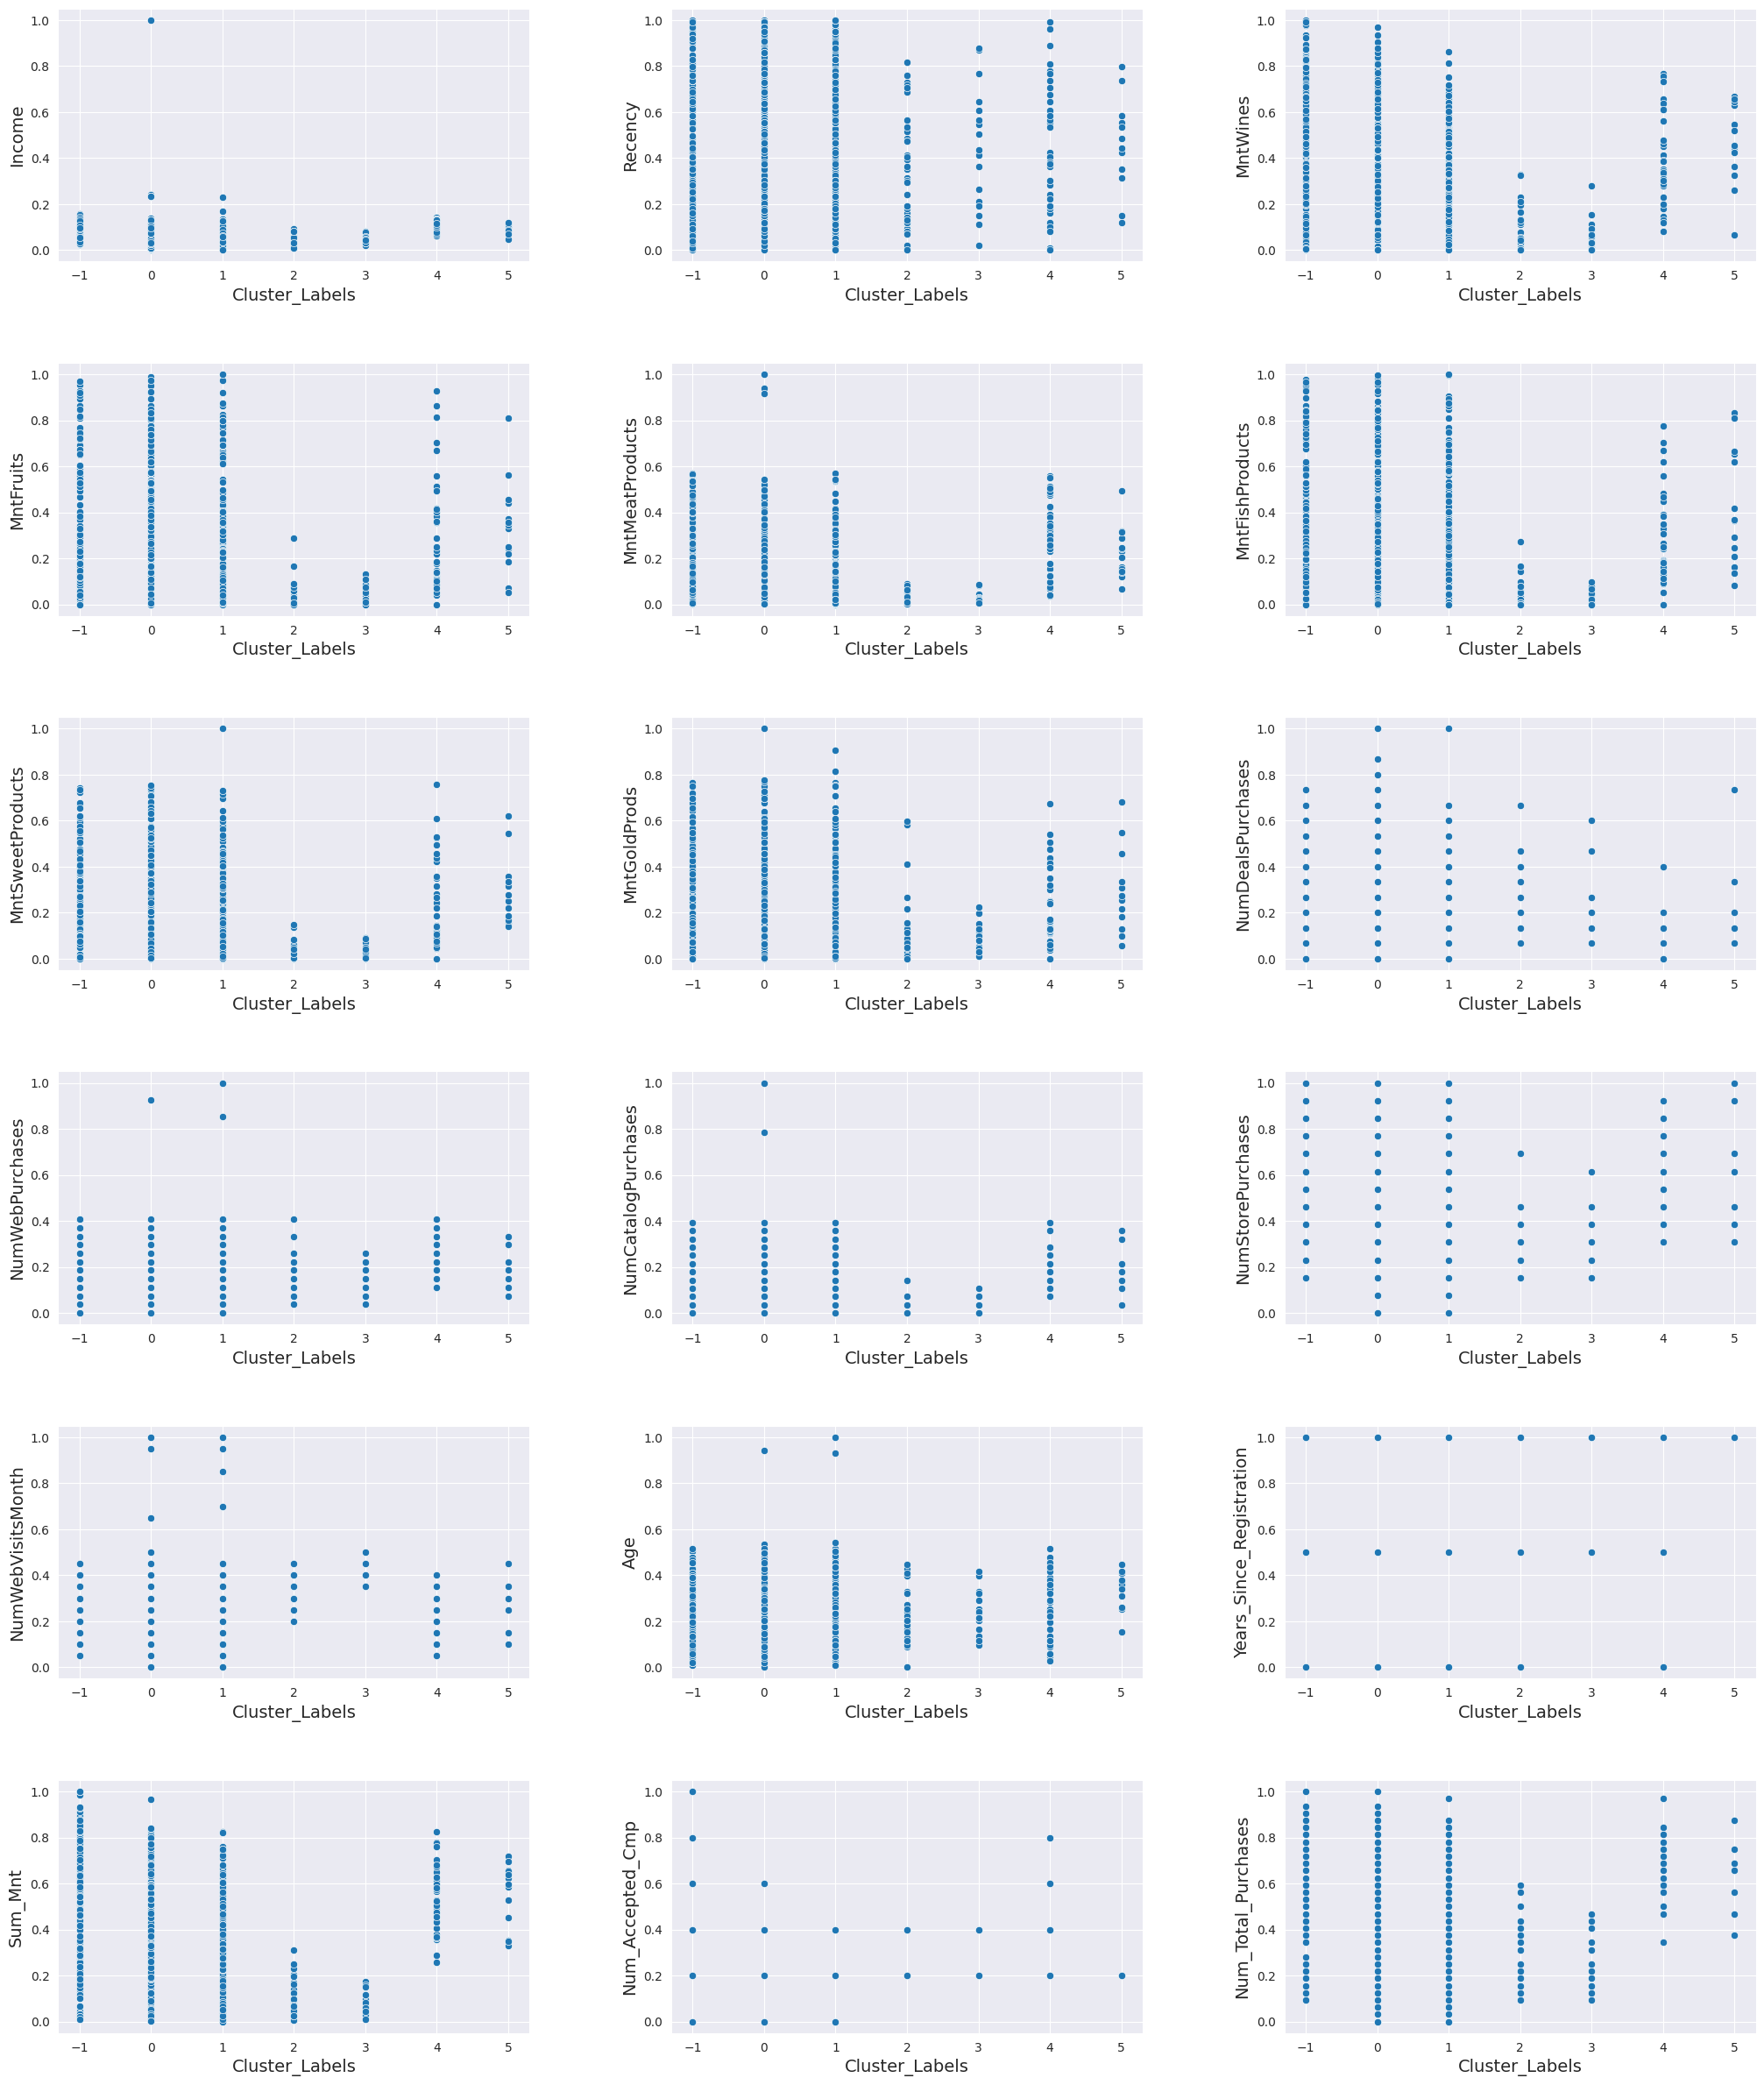

In [56]:
def scatterplot():
    n_cols = len(num_cols)
    rows = n_cols // 3
    _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    for num, col in enumerate(num_cols):
        s = sns.scatterplot(
            data=df,
            x="Cluster_Labels",
            y=col,
            palette="Paired",
            ax=axes.reshape(-1)[num]
        )
        s.set_xlabel('Cluster_Labels', fontsize=14)
        s.set_ylabel(f'{col}', fontsize=14)
        sns.set_style('darkgrid')

scatterplot()

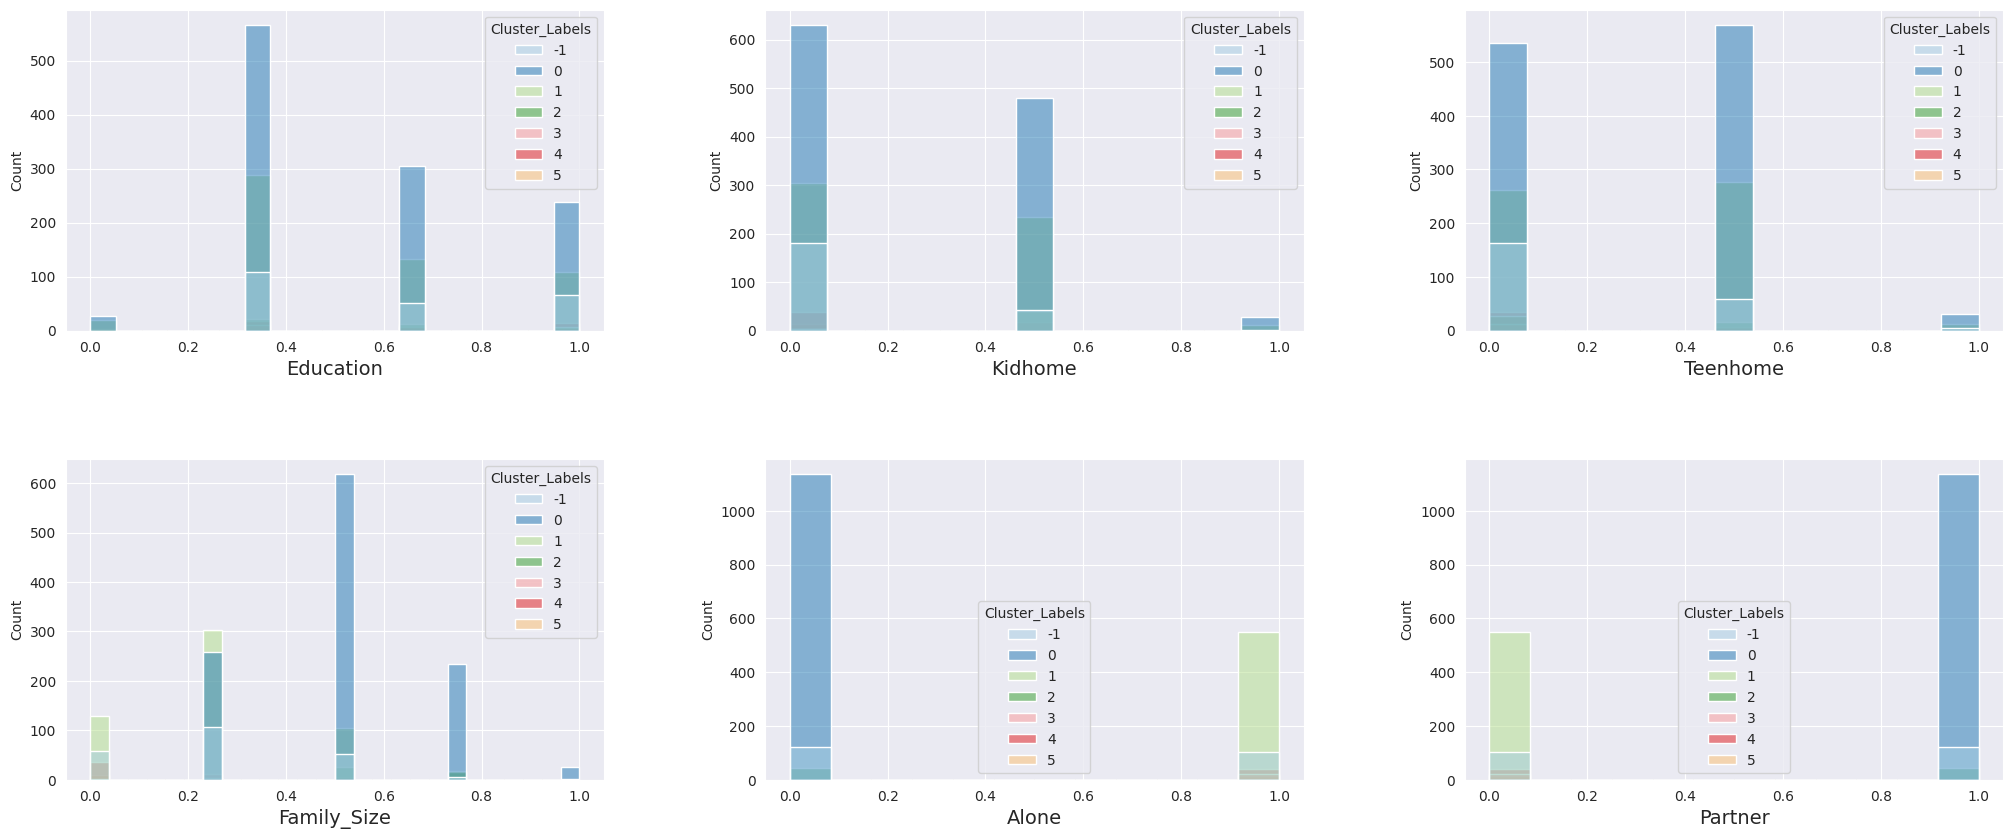

In [57]:
def histplot():
    n_cols = len(object_cols)
    rows = n_cols // 3
    _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    for num, col in enumerate(object_cols):
        # Ensure the column contains numerical data
        if df[col].dtype in [int, float]:
            h = sns.histplot(
                data=df,
                x=col,
                hue="Cluster_Labels",  # Use "Clusters" as the hue for different colors
                palette="Paired",
                ax=axes.reshape(-1)[num]
            )
            h.set_xlabel(f'{col}', fontsize=14)
            sns.set_style('darkgrid')

histplot()


<Axes: xlabel='Cluster_Labels', ylabel='Income'>

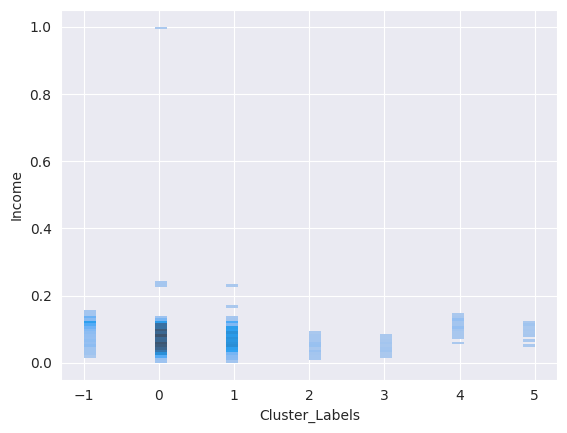

In [58]:
sns.histplot(x=df['Cluster_Labels'],y=df['Income'])

<Axes: xlabel='Cluster_Labels', ylabel='Age'>

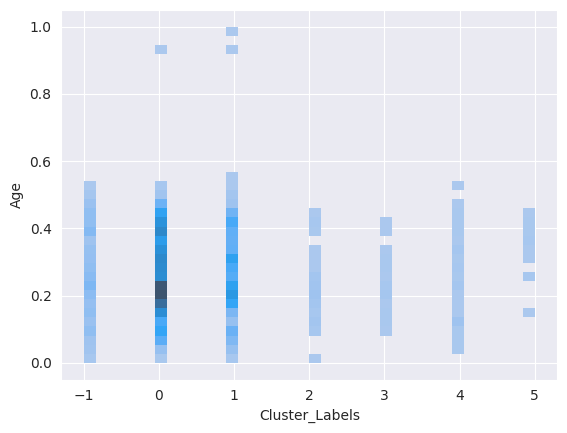

In [59]:
sns.histplot(x=df['Cluster_Labels'],y=df['Age'])

<Axes: xlabel='Cluster_Labels', ylabel='Num_Total_Purchases'>

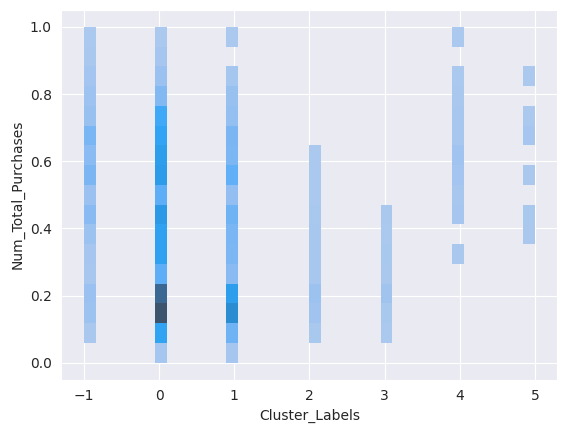

In [60]:
sns.histplot(x=df['Cluster_Labels'],y=df['Num_Total_Purchases'])

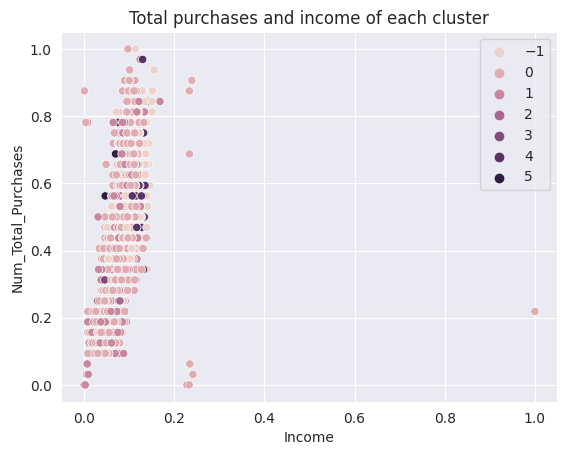

In [61]:
pl = sns.scatterplot(data = df, x=df["Income"], y=df["Num_Total_Purchases"], hue=df["Cluster_Labels"])
pl.set_title("Total purchases and income of each cluster")
plt.legend()
plt.show()

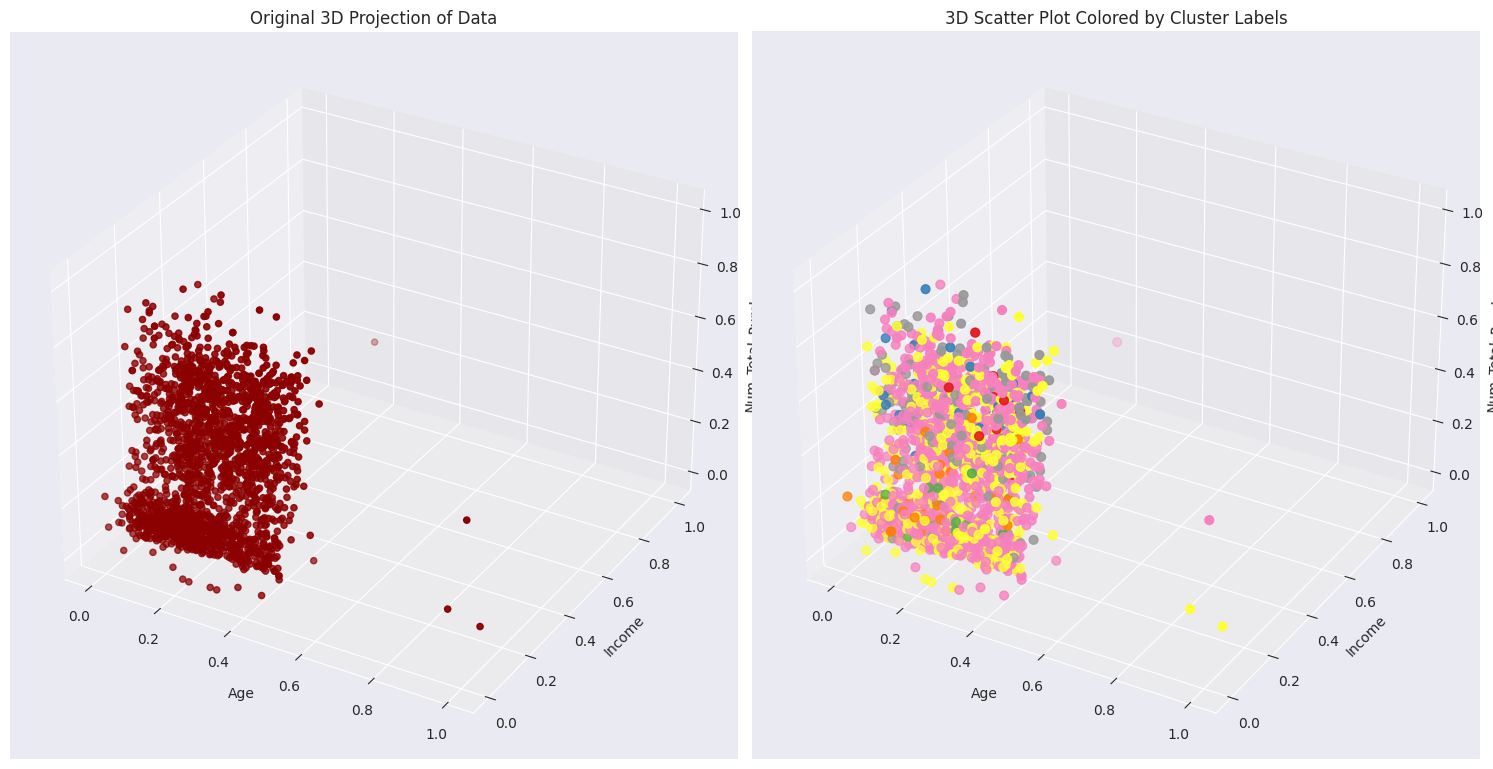

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Original 3D Scatter Plot
x = df['Age']
y = df['Income']
z = df['Num_Total_Purchases']

fig = plt.figure(figsize=(15, 8))  # Adjust the figsize parameter

# Subplot 1: Original 3D Scatter Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z, c='darkred', marker='o')
ax1.set_title('Original 3D Projection of Data')

ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
ax1.set_zlabel('Num_Total_Purchases')

# Subplot 2: 3D Scatter Plot with Cluster Labels
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, z, s=40, c=df['Cluster_Labels'], marker='o', cmap='Set1_r')
ax2.set_title('3D Scatter Plot Colored by Cluster Labels')

ax2.set_xlabel('Age')
ax2.set_ylabel('Income')
ax2.set_zlabel('Num_Total_Purchases')

# Adjust the distance between the subplots
plt.subplots_adjust(wspace=0.1)  # Reduce the width space between subplots

plt.tight_layout()
plt.show()


Increasing Silhouette score:
1. Normalization is performing better or standardization & then proceed with any one scaling
2. PCA components, increase the cumulative explained variance ratio increase it to threshold= 80% and not less than 95%, check how the model is performing now.
2. Hyperparamete tuning in the algo like euclidean, manhattan, epsilon for diff. algo's

1. The clusters should be symmetrical and not overlapping
2. you can keep the pca to 4,5,8 as if it is selecting 20 PCA based on the explaiend variance ratio, with threshold >80%
3. DBSCAN is the best clustering, so use it and don't give default value of eigen vector,.... something something


In [63]:
# Assuming you have a DataFrame named df and want to drop certain columns
columns_to_drop = ['Education','Income','Kidhome', 'Teenhome']  # List of column names to drop

df_tr = df_transform.drop(columns=columns_to_drop)

In [64]:
df_tr.shape

(2031, 1)

In [65]:
df_scaled.shape

(2031, 31)

In [66]:
con_df= pd.concat([df_scaled,df_tr['Cluster_Labels']],axis=1)

In [67]:
con_df

Education    Income  Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0      0.333333  0.104102      0.0       0.0  0.666667  0.160080   0.050251   
1      0.333333  0.083258      0.0       0.0  0.000000  0.310784   0.025126   
2      0.666667  0.066725      0.5       0.5  0.868687  0.038178   0.000000   
3      1.000000  0.035534      0.0       0.5  0.575758  0.012726   0.000000   
4      1.000000  0.088371      0.0       0.5  0.818182  0.426658   0.236181   
...         ...       ...      ...       ...       ...       ...        ...   
2016        NaN       NaN      NaN       NaN       NaN       NaN        NaN   
2017        NaN       NaN      NaN       NaN       NaN       NaN        NaN   
2026        NaN       NaN      NaN       NaN       NaN       NaN        NaN   
2027        NaN       NaN      NaN       NaN       NaN       NaN        NaN   
2029        NaN       NaN      NaN       NaN       NaN       NaN        NaN   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Response  \
0            0.321159         0.980695          0.332061  ...       0.0   
1            0.037101         0.027027          0.000000  ...       1.0   
2            0.015652         0.000000          0.000000  ...       0.0   
3            0.002899         0.000000          0.000000  ...       0.0   
4            0.137391         0.046332          0.072519  ...       0.0   
...               ...              ...               ...  ...       ...   
2016              NaN              NaN               NaN  ...       NaN   
2017              NaN              NaN               NaN  ...       NaN   
2026              NaN              NaN               NaN  ...       NaN   
2027              NaN              NaN               NaN  ...       NaN   
2029              NaN              NaN               NaN  ...       NaN   

           Age  Years_Since_Registration  Family_Size  Alone  Partner  \
0     0.106796                       0.5         0.25    0.0      1.0   
1     0.339806                       0.0         0.00    1.0      0.0   
2     0.203883                       1.0         0.50    1.0      0.0   
3     0.475728                       0.5         0.25    1.0      0.0   
4     0.242718                       0.5         0.50    0.0      1.0   
...        ...                       ...          ...    ...      ...   
2016       NaN                       NaN          NaN    NaN      NaN   
2017       NaN                       NaN          NaN    NaN      NaN   
2026       NaN                       NaN          NaN    NaN      NaN   
2027       NaN                       NaN          NaN    NaN      NaN   
2029       NaN                       NaN          NaN    NaN      NaN   

       Sum_Mnt  Num_Accepted_Cmp  Num_Total_Purchases  Cluster_Labels  
0     0.473413               0.0              0.50000             0.0  
1     0.226984               0.4              0.53125            -1.0  
2     0.045635               0.0              0.21875             1.0  
3     0.010714               0.0              0.12500             1.0  
4     0.405952               0.0              0.75000             0.0  
...        ...               ...                  ...             ...  
2016       NaN               NaN                  NaN             0.0  
2017       NaN               NaN                  NaN             0.0  
2026       NaN               NaN                  NaN             0.0  
2027       NaN               NaN                  NaN             1.0  
2029       NaN               NaN                  NaN             1.0  

[2211 rows x 32 columns]

In [68]:
for column in con_df.columns:
    inc_med = con_df[column].median()

    # Adjusted scaled range limits (e.g., for normalization between 0 and 1)
    lower_limit = 0  # Adjust based on your scaled range
    upper_limit = 1  # Adjust based on your scaled range

    # Calculate capped median value
    capped_median = max(lower_limit, min(upper_limit, inc_med))

    # Fill missing values with the capped median
    con_df[column] = con_df[column].fillna(capped_median)

In [69]:
con_df.isna().sum()

Education                   0
Income                      0
Kidhome                     0
Teenhome                    0
Recency                     0
MntWines                    0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Response                    0
Age                         0
Years_Since_Registration    0
Family_Size                 0
Alone                       0
Partner                     0
Sum_Mnt                     0
Num_Accepted_Cmp            0
Num_Total_Purchases         0
Cluster_Labels              0
dtype: int64

In [70]:
con_df.shape

(2211, 32)

In [71]:
con_df.head()

Education    Income  Kidhome  Teenhome   Recency  MntWines  MntFruits  \
0   0.333333  0.104102      0.0       0.0  0.666667  0.160080   0.050251   
1   0.333333  0.083258      0.0       0.0  0.000000  0.310784   0.025126   
2   0.666667  0.066725      0.5       0.5  0.868687  0.038178   0.000000   
3   1.000000  0.035534      0.0       0.5  0.575758  0.012726   0.000000   
4   1.000000  0.088371      0.0       0.5  0.818182  0.426658   0.236181   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Response  \
0         0.321159         0.980695          0.332061  ...       0.0   
1         0.037101         0.027027          0.000000  ...       1.0   
2         0.015652         0.000000          0.000000  ...       0.0   
3         0.002899         0.000000          0.000000  ...       0.0   
4         0.137391         0.046332          0.072519  ...       0.0   

        Age  Years_Since_Registration  Family_Size  Alone  Partner   Sum_Mnt  \
0  0.106796                       0.5         0.25    0.0      1.0  0.473413   
1  0.339806                       0.0         0.00    1.0      0.0  0.226984   
2  0.203883                       1.0         0.50    1.0      0.0  0.045635   
3  0.475728                       0.5         0.25    1.0      0.0  0.010714   
4  0.242718                       0.5         0.50    0.0      1.0  0.405952   

   Num_Accepted_Cmp  Num_Total_Purchases  Cluster_Labels  
0               0.0              0.50000             0.0  
1               0.4              0.53125            -1.0  
2               0.0              0.21875             1.0  
3               0.0              0.12500             1.0  
4               0.0              0.75000             0.0  

[5 rows x 32 columns]

In [72]:
# Remove rows with cluster label -1
df_new= con_df[con_df['Cluster_Labels'] != -1]

df_new.shape

(1986, 32)

In [73]:
# Save the DataFrame to a CSV file
csv_filename = 'df_new.csv'
df_new.to_csv(csv_filename, index=False)

print("DataFrame saved to", csv_filename)

DataFrame saved to df_new.csv


In [74]:
#split X and Y variable
y=df_new["Cluster_Labels"]
X=df_new.drop(["Cluster_Labels"],axis=1)

In [75]:
X.shape

(1986, 31)

In [76]:
y.shape

(1986,)

In [77]:
var= list(X)
var

['Education',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response',
 'Age',
 'Years_Since_Registration',
 'Family_Size',
 'Alone',
 'Partner',
 'Sum_Mnt',
 'Num_Accepted_Cmp',
 'Num_Total_Purchases']

In [78]:
pd.value_counts(y)

0.0    1316
1.0     551
2.0      44
4.0      40
3.0      21
5.0      14
Name: Cluster_Labels, dtype: int64

In [79]:
y.mean()

0.4692849949647533

## Train Test Split

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [82]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1390, 31) (596, 31) (1390,) (596,)


In [83]:
X_val

Education    Income  Kidhome  Teenhome   Recency  MntWines  MntFruits  \
1615   1.000000  0.068249      0.0       0.5  0.353535  0.398526   0.356784   
1066   0.666667  0.043648      0.5       0.5  0.858586  0.008038   0.025126   
1332   0.333333  0.043761      0.5       0.0  0.161616  0.010717   0.055276   
611    0.666667  0.055479      0.0       0.0  0.565657  0.075017   0.085427   
1346   1.000000  0.081036      0.0       0.0  0.858586  0.337575   0.065327   
...         ...       ...      ...       ...       ...       ...        ...   
1880   0.333333  0.058749      0.0       0.5  0.181818  0.174816   0.115578   
991    0.666667  0.066719      0.5       0.5  0.626263  0.008038   0.010050   
552    1.000000  0.151037      0.0       0.0  0.545455  0.511052   0.145729   
1460   0.333333  0.090922      0.0       0.0  0.494949  0.530476   0.000000   
145    0.666667  0.087875      0.0       0.5  0.171717  0.391159   0.221106   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Complain  \
1615         0.088696         0.463320          0.427481  ...       0.0   
1066         0.014493         0.000000          0.034351  ...       0.0   
1332         0.008696         0.007722          0.000000  ...       0.0   
611          0.025507         0.131274          0.083969  ...       0.0   
1346         0.075942         0.030888          0.000000  ...       0.0   
...               ...              ...               ...  ...       ...   
1880         0.042319         0.015444          0.087786  ...       0.0   
991          0.011594         0.011583          0.007634  ...       0.0   
552          0.080000         0.293436          0.671756  ...       0.0   
1460         0.159420         0.173745          0.171756  ...       0.0   
145          0.122899         0.177606          0.030534  ...       0.0   

      Response       Age  Years_Since_Registration  Family_Size  Alone  \
1615       0.0  0.242718                       1.0         0.25    1.0   
1066       0.0  0.281553                       0.5         0.75    0.0   
1332       0.0  0.155340                       0.5         0.25    1.0   
611        0.0  0.320388                       0.5         0.25    0.0   
1346       0.0  0.504854                       0.5         0.00    1.0   
...        ...       ...                       ...          ...    ...   
1880       0.0  0.203883                       0.5         0.50    0.0   
991        0.0  0.223301                       0.0         0.75    0.0   
552        1.0  0.184466                       1.0         0.25    0.0   
1460       0.0  0.378641                       0.5         0.25    0.0   
145        0.0  0.300971                       1.0         0.25    1.0   

      Partner   Sum_Mnt  Num_Accepted_Cmp  Num_Total_Purchases  
1615      0.0  0.431349               0.0              0.46875  
1066      1.0  0.030159               0.0              0.15625  
1332      0.0  0.020238               0.0              0.18750  
611       1.0  0.124206               0.0              0.31250  
1346      0.0  0.268651               0.2              0.59375  
...       ...       ...               ...                  ...  
1880      1.0  0.170238               0.0              0.43750  
991       1.0  0.015476               0.0              0.12500  
552       1.0  0.490079               0.8              0.81250  
1460      1.0  0.507143               0.0              0.53125  
145       0.0  0.423016               0.0              0.71875  

[596 rows x 31 columns]

In [84]:
import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from scipy.stats import ks_2samp
import matplotlib.pyplot as pl

from sklearn.preprocessing import StandardScaler
from joblib import dump, load

## MODELLING

## 1. DECISION TREE

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a DecisionTreeClassifier instance
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Predict labels for training and validation data
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Print actual and predicted values
print("Actual values for validation set:", y_val[:10])
print("Predicted values for validation set:", y_val_pred[:10])


Training Accuracy: 0.9669064748201439
Validation Accuracy: 0.5134228187919463
Actual values for validation set: 1615    1.0
1066    0.0
1332    0.0
611     0.0
1346    0.0
454     0.0
2130    0.0
1132    0.0
2220    0.0
969     1.0
Name: Cluster_Labels, dtype: float64
Predicted values for validation set: [0. 1. 0. 0. 0. 0. 0. 0. 1. 4.]


Model Evaluation:

In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.52015931736757
Recall: 0.5134228187919463
F1-Score: 0.5167481119036169
Confusion Matrix:
 [[260 106  11   3  12   3]
 [108  46   3   1   7   1]
 [  7   4   0   0   2   0]
 [  5   1   0   0   0   0]
 [ 10   1   0   0   0   1]
 [  2   1   0   0   1   0]]


Hyperparameter Tuning:

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


Overfitting Detection and Mitigation:

In [93]:
clf = DecisionTreeClassifier(random_state=42, max_depth=10)


Feature Importance:

In [94]:
from sklearn.metrics import accuracy_score

# Create a DecisionTreeClassifier instance
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Access feature importances
feature_importances = clf.feature_importances_
print("Feature Importances:\n", feature_importances)


Feature Importances:
 [0.02443679 0.09465915 0.00601957 0.01018312 0.05021475 0.06038068
 0.0471047  0.08380282 0.04804016 0.06018364 0.0838861  0.02705493
 0.02389034 0.03256697 0.03101668 0.03882187 0.00306828 0.00750958
 0.         0.0016417  0.00400952 0.00511234 0.00608102 0.0938452
 0.01743249 0.01025465 0.00697564 0.         0.06673036 0.01450695
 0.04057001]


In [95]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Create a DecisionTreeClassifier instance
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Create a DataFrame to pair feature names with their importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                     Feature  Importance
1                     Income    0.094659
23                       Age    0.093845
10              MntGoldProds    0.083886
7            MntMeatProducts    0.083803
28                   Sum_Mnt    0.066730
5                   MntWines    0.060381
9           MntSweetProducts    0.060184
4                    Recency    0.050215
8            MntFishProducts    0.048040
6                  MntFruits    0.047105
30       Num_Total_Purchases    0.040570
15         NumWebVisitsMonth    0.038822
13       NumCatalogPurchases    0.032567
14         NumStorePurchases    0.031017
11         NumDealsPurchases    0.027055
0                  Education    0.024437
12           NumWebPurchases    0.023890
24  Years_Since_Registration    0.017432
29          Num_Accepted_Cmp    0.014507
25               Family_Size    0.010255
3                   Teenhome    0.010183
17              AcceptedCmp4    0.007510
26                     Alone    0.006976
22              

Visualizing the Tree:

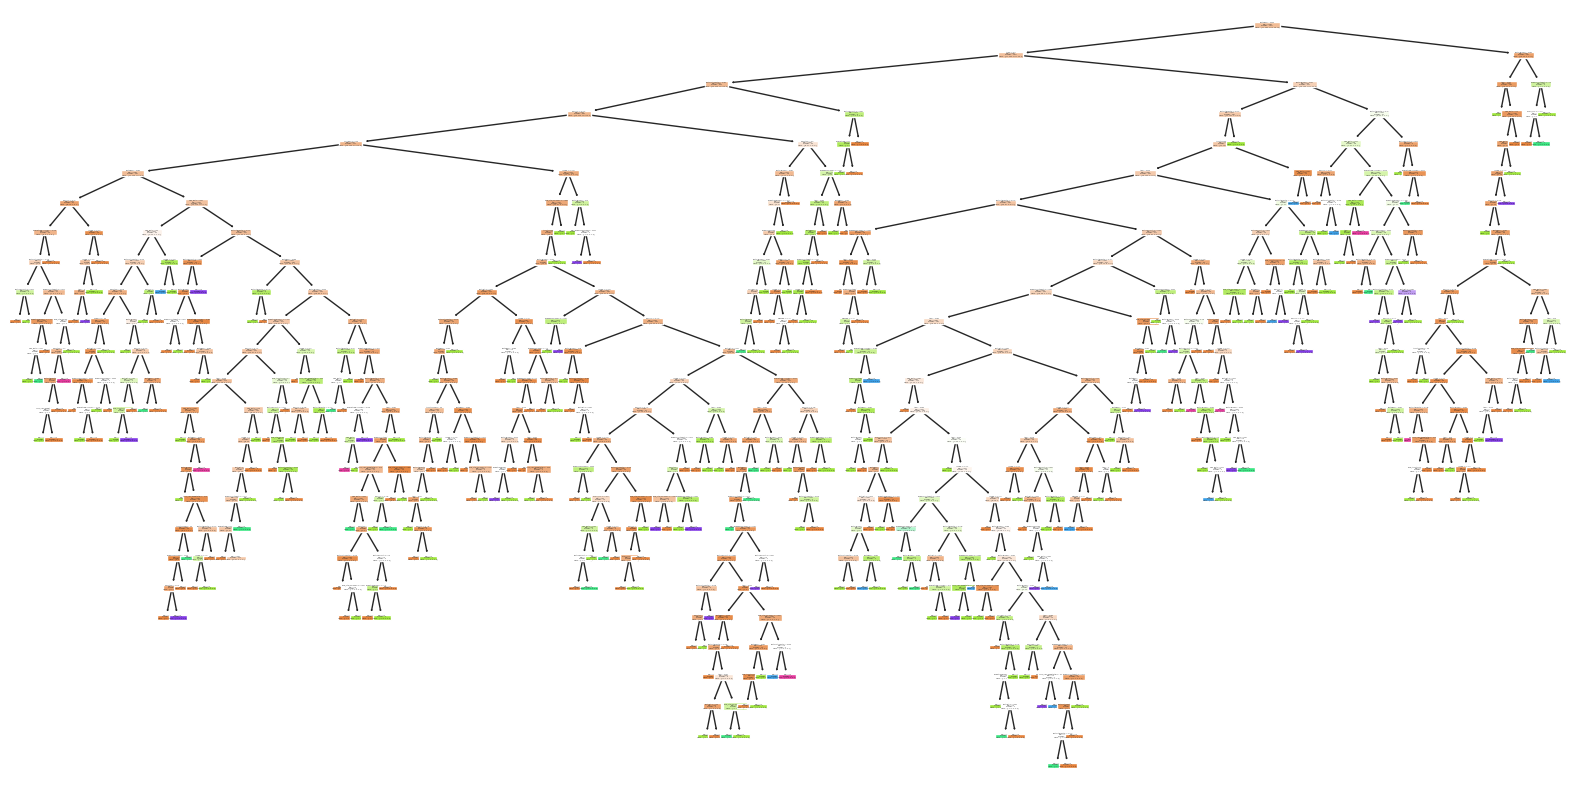

In [96]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()


## 2. RANDOM FOREST

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
final_rf_classifier = RandomForestClassifier(**best_params, random_state=42)

# Fit the final model on the training data
final_rf_classifier.fit(X_train, y_train)

# Predict labels for validation data
y_val_pred = final_rf_classifier.predict(X_val)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, final_rf_classifier.predict(X_train))
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training Accuracy: 0.7971223021582734
Validation Accuracy: 0.6593959731543624


In [104]:
# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict labels for validation data
y_val_pred = rf_classifier.predict(X_val)

# Calculate accuracy score
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Print actual and predicted values
print("Actual values for validation set:", y_val[:10])
print("Predicted values for validation set:", y_val_pred[:10])


Validation Accuracy: 0.6493288590604027
Actual values for validation set: 1615    1.0
1066    0.0
1332    0.0
611     0.0
1346    0.0
454     0.0
2130    0.0
1132    0.0
2220    0.0
969     1.0
Name: Cluster_Labels, dtype: float64
Predicted values for validation set: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Confusion Matrix:

In [105]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

Precision, Recall, and F1-Score:

In [106]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F1-score
report = classification_report(y_val, y_val_pred)

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.97      0.79       395
         1.0       0.20      0.02      0.03       166
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         4

    accuracy                           0.65       596
   macro avg       0.14      0.17      0.14       596
weighted avg       0.49      0.65      0.53       596



Feature Importance Analysis:

In [107]:
importances = rf_classifier.feature_importances_
feature_names = X_train.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", importance_df)


Feature Importances:
                      Feature  Importance
1                     Income    0.077137
5                   MntWines    0.072979
4                    Recency    0.072308
23                       Age    0.068834
28                   Sum_Mnt    0.066873
10              MntGoldProds    0.065327
7            MntMeatProducts    0.064757
6                  MntFruits    0.059934
9           MntSweetProducts    0.057675
8            MntFishProducts    0.052868
30       Num_Total_Purchases    0.040322
15         NumWebVisitsMonth    0.036874
14         NumStorePurchases    0.033377
12           NumWebPurchases    0.031673
13       NumCatalogPurchases    0.028251
11         NumDealsPurchases    0.027982
0                  Education    0.022178
24  Years_Since_Registration    0.020952
25               Family_Size    0.017485
29          Num_Accepted_Cmp    0.013977
3                   Teenhome    0.012540
2                    Kidhome    0.010411
27                   Partner    0.0

## 3. XGBoost

In [108]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Create an XGBoost classifier instance
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final XGBoost model
final_xgb_classifier = xgb.XGBClassifier(**best_params, random_state=42)

# Fit the final model on the training data
final_xgb_classifier.fit(X_train, y_train)

# Predict labels for validation data
y_val_pred = final_xgb_classifier.predict(X_val)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
Training Accuracy: 0.9669064748201439
Validation Accuracy: 0.6577181208053692


In [109]:
# Predict labels for validation data
y_val_pred = final_xgb_classifier.predict(X_val)

# Display actual vs. predicted values for validation data
results_df = pd.DataFrame({'Actual': y_val[:10], 'Predicted': y_val_pred[:10]})
print("\nActual vs. Predicted:\n", results_df)


Actual vs. Predicted:
       Actual  Predicted
1615     1.0          0
1066     0.0          0
1332     0.0          0
611      0.0          0
1346     0.0          0
454      0.0          0
2130     0.0          0
1132     0.0          0
2220     0.0          0
969      1.0          0


Confusion Matrix:

Precision, Recall, and F1-Score:

In [110]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F1-score
report = classification_report(y_val, y_val_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.99      0.79       395
         1.0       0.17      0.01      0.01       166
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         4

    accuracy                           0.66       596
   macro avg       0.14      0.17      0.13       596
weighted avg       0.49      0.66      0.53       596



Feature Importance Analysis:

In [111]:
importances = final_xgb_classifier.feature_importances_
feature_names = X_train.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", importance_df)

Feature Importances:
                      Feature  Importance
29          Num_Accepted_Cmp    0.076983
3                   Teenhome    0.069839
10              MntGoldProds    0.063429
25               Family_Size    0.059776
21                  Complain    0.057220
0                  Education    0.052691
7            MntMeatProducts    0.052557
28                   Sum_Mnt    0.051797
9           MntSweetProducts    0.042333
26                     Alone    0.042169
5                   MntWines    0.040974
4                    Recency    0.040183
23                       Age    0.039408
30       Num_Total_Purchases    0.037247
17              AcceptedCmp4    0.036342
15         NumWebVisitsMonth    0.035938
8            MntFishProducts    0.034992
1                     Income    0.031436
24  Years_Since_Registration    0.027638
13       NumCatalogPurchases    0.027005
11         NumDealsPurchases    0.024669
6                  MntFruits    0.018248
12           NumWebPurchases    0.0

## Cross-Validation of all the models:

In [114]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Assuming you have your data loaded as X_train, y_train, X_test, y_test

# Create instances of different classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = xgb.XGBClassifier(random_state=42)

# List of classifiers
classifiers = [dt_classifier, rf_classifier, xgb_classifier]
classifier_names = ['Decision Tree', 'Random Forest', 'XGBoost']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation and compare accuracy scores
for clf, name in zip(classifiers, classifier_names):
    # Cross-validation scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    # Calculate mean cross-validation score
    mean_cv_score = np.mean(cv_scores)

    # Fit the classifier and predict on test set
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate accuracy score
    acc_score = accuracy_score(y_test, y_pred)

    # Print results
    print(f"{name}")
    print(f"Accuracy Score: {acc_score}")
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {mean_cv_score}")
    print()

Decision Tree
Accuracy Score: 0.5201005025125628
Cross-Validation Scores: [0.51257862 0.53144654 0.5408805  0.53943218 0.51104101]
Mean CV Score: 0.5270757692994464

Random Forest
Accuracy Score: 0.635678391959799
Cross-Validation Scores: [0.66352201 0.65408805 0.64779874 0.66561514 0.65930599]
Mean CV Score: 0.6580659881356268

XGBoost
Accuracy Score: 0.5904522613065326
Cross-Validation Scores: [0.62893082 0.60377358 0.6509434  0.64353312 0.62460568]
Mean CV Score: 0.6303573200007937



Considering the accuracy scores and mean cross-validation scores, it appears that the Logistic Regression and Random Forest classifiers have the highest accuracy and mean CV scores among the models you've tested. If interpretability is a concern, Logistic Regression might be a better choice. If you're looking for more predictive power and are comfortable with potentially higher complexity, Random Forest might be preferred.

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final model
final_rf_classifier = RandomForestClassifier(**best_params, random_state=42)

# Fit the final model on the training data
final_rf_classifier.fit(X_train, y_train)

# You can return final_rf_classifier if you want to use it in other parts of your code


RandomForestClassifier(min_samples_leaf=4, random_state=42)

In [117]:
import pickle

# Save the trained model using pickle
model_filename_pickle = 'random_forest.pkl'

# Save using pickle
with open(model_filename_pickle, 'wb') as file:
    pickle.dump(final_rf_classifier, file)

print("Model saved using pickle to", model_filename_pickle)

Model saved using pickle to random_forest.pkl
